This notebook is used to analyze the FActScores computed.

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import config
import plotly.express as px
import tikzplotlib
from tqdm import tqdm
import urllib.parse
import py3langid as langid

In [2]:
languages=config.languages
lang_cat=config.lang_cat
data_dir='../data/'
results_dir='../result/scores/'
fig_dir='../report/Images/'

In [3]:
experiments=config.experiments
models=list(config.checkpoints.keys())

# Data Importation

In [4]:
pers_df=pd.read_csv(data_dir+'clean_people_analysis.csv')
pers_df['link']= "http://www.wikidata.org/entity/"+pers_df['code']

In [5]:
page_views_df=pd.read_csv(data_dir+'pageviews.csv')
page_views_df.rename(columns={'link_wiki':'link'}, inplace=True)

In [6]:
result_df=pd.read_csv(results_dir+"all_scores.csv")

In [7]:
nli_df=pd.read_csv(results_dir+"new_all_nliscores.csv")

In [8]:
rouge_df=pd.read_csv(results_dir+"all_rougescores.csv")

In [9]:
result_df=result_df.merge(rouge_df, on=['link', 'experiment', 'lang', 'model'], how='left').merge(nli_df, on=['link', 'experiment', 'lang', 'model'], how='left')

# Mistral validation

Code to compute F1-scores with human annotated data.

In [7]:
models=['InstructGPT', 'ChatGPT', 'PerplexityAI']

In [8]:
def compute_ER(human_labels, model_labels):
    # Calculate Factscores
    human_FS=sum(1 for h in human_labels if h == 'S')/len(human_labels)
    model_FS=sum(1 for m in model_labels if m == 'S')/len(model_labels)

    # Return error rate
    return abs(human_FS-model_FS)

In [27]:
def compute_F1micro(human_labels, model_labels, label='NS'):
    P_inter_G = sum(1 for h, m in zip(human_labels, model_labels) if h == label and m == label)
    P = sum(1 for m in model_labels if m == label)
    G = sum(1 for h in human_labels if h == label)

    precision = P_inter_G / P if P>0 else 0
    recall= P_inter_G/G if G>0 else 0
    f1_micro = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return round(f1_micro*100, 2)

In [34]:
with open(results_dir+f"scores/scores_validation.json", 'r') as f:
    labels=json.load(f)

In [31]:
methods=['AlwaysNS','NP','ChatGPT', 'Llama+NP','Llama3+NP', 'Mistral', 'Mistral+NP']
f1={}
er={}
for m in models:
    f1[m]={}
    er[m]={}
    people_labels=labels[m]
    for k in methods:
        method_er, merged_human_labels, merged_model_labels=[], [], []
        for person, labels_dict in people_labels.items():
            if k in labels_dict:
                merged_human_labels.extend(labels_dict['human'])
                merged_model_labels.extend(labels_dict[k])
                method_er.append(compute_ER(labels_dict['human'], labels_dict[k]))
        f1[m][k]=compute_F1micro(merged_human_labels, merged_model_labels)
        er[m][k]=np.mean(method_er)

In [32]:
pd.DataFrame(f1)

,InstructGPT,ChatGPT,PerplexityAI
AlwaysNS,71.44,58.29,30.90
NP,70.10,56.56,51.40
ChatGPT,86.16,68.55,54.95
Llama+NP,73.26,60.20,39.63
Llama3+NP,70.10,56.56,51.40
Mistral,85.40,73.46,58.43
Mistral+NP,84.76,74.04,56.34


In [33]:
pd.DataFrame(er)

,InstructGPT,ChatGPT,PerplexityAI
AlwaysNS,0.428111,0.582991,0.803832
NP,0.189170,0.176842,0.108904
ChatGPT,0.140155,0.180379,0.088003
Llama+NP,0.222744,0.286351,0.360188
Llama3+NP,0.189170,0.176842,0.108904
Mistral,0.089647,0.107839,0.113488
Mistral+NP,0.108502,0.120961,0.167831


# FACTSCORE

In [12]:
result_df['lang_cat']=result_df['lang'].map(lang_cat)

In [13]:
result_df.isna().sum()

link                  0
experiment            0
lang                  0
model                 0
fs_mean               8
fs_std                8
nb_facts_mean         8
nb_facts_std          8
init_score            8
respond_ratio         0
r1_f1-mean       149568
r1_f1-std        149568
r1_p-mean             0
r1_p-std              0
r1_r-mean             0
r1_r-std              0
rl_f1-mean            0
rl_f1-std             0
rl_p-mean             0
rl_p-std              0
rl_r-mean             0
rl_r-std              0
lang_cat              0
dtype: int64

In [14]:
result_df[result_df.respond_ratio!=1.0]

,link,experiment,lang,model,fs_mean,fs_std,nb_facts_mean,nb_facts_std,init_score,respond_ratio,...,r1_p-std,r1_r-mean,r1_r-std,rl_f1-mean,rl_f1-std,rl_p-mean,rl_p-std,rl_r-mean,rl_r-std,lang_cat
67,http://www.wikidata.org/entity/Q35149,multi,ar,llama_8,0.350000,0.050000,10.0,0.0,0.350000,0.666667,...,0.039778,0.916667,0.117851,0.298643,0.048454,0.181974,0.039778,0.916667,0.117851,Medium
97,http://www.wikidata.org/entity/Q35314,multi,zh,llama_8,0.432702,0.175994,14.5,8.5,0.554348,0.666667,...,0.018669,0.269231,0.083086,0.140314,0.004213,0.109479,0.014299,0.217949,0.065372,High
128,http://www.wikidata.org/entity/Q35648,multi,bn,llama_8,0.504307,0.132056,9.0,2.0,0.603896,0.666667,...,0.000000,1.000000,0.000000,0.750000,0.000000,0.600000,0.000000,1.000000,0.000000,Low
142,http://www.wikidata.org/entity/Q35811,multi,ko,llama_8,0.272013,0.105346,38.5,14.5,0.272013,0.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Medium
219,http://www.wikidata.org/entity/Q36153,multi,ar,llama_8,0.689356,0.037917,9.0,2.0,0.863636,0.666667,...,0.028405,0.316239,0.024175,0.216112,0.032530,0.180031,0.027066,0.273504,0.052687,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145489,http://www.wikidata.org/entity/Q2494,enprompt,th,aya_35,0.256709,0.085570,6.0,0.0,0.500000,0.666667,...,0.112996,0.014440,0.006424,0.023529,0.009400,0.185829,0.084846,0.012635,0.005105,Medium
146404,http://www.wikidata.org/entity/Q57327,enprompt,bn,aya_35,0.362857,0.077143,19.5,5.5,0.362857,0.666667,...,0.229113,0.196643,0.124099,0.189179,0.113250,0.276982,0.162427,0.143885,0.086928,Low
146888,http://www.wikidata.org/entity/Q8413,enprompt,jv,aya_35,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,0.131325,0.000000,0.162749,0.000000,0.326087,0.000000,0.108434,0.000000,Low
148199,http://www.wikidata.org/entity/Q11817,enprompt,zh,aya_35,0.733701,0.064279,110.0,11.0,0.733701,0.666667,...,0.313823,0.314626,0.223046,0.170509,0.120580,0.205794,0.145806,0.145692,0.103041,High


In [15]:
import re

def reformat(tex_file, new_file=None):
    if not new_file:
        new_file=tex_file
    # Read content from the file
    with open(tex_file, 'r') as f:
        content=f.read()

    # Extract TikZ code before \path
    pattern = re.compile(r'^(.*?)\\begin{axis}', re.DOTALL)
    match = pattern.search(content)

    if match:
        new_tikz_code = match.group(1).strip()
        new_tikz_code+='\n'
    else:
        print("No \\begin command found.")   
    
    new_tikz_code+="""\\begin{axis}[width=\linewidth,height=0.3\linewidth,
        axis line style={lightgray204},
        xtick pos=left,
        ytick pos=left,
        legend cell align={left},
        legend columns=19,
        legend style={
        fill opacity=0.8,
        draw opacity=1,
        text opacity=1,
        at={(0.5,1)},
        anchor=south,
        draw=lightgray204,
        column sep=0.01cm,
        font={\\footnotesize\\arraycolsep=2pt}
        },
        legend image code/.code={%
                            \draw (-0.15cm,-0.1cm) rectangle (0.15cm,0.1cm);
                        },   
        tick align=outside,
        x grid style={lightgray204},
        xlabel=\\textcolor{darkslategray38}{Experiment},
        xmin=-0.5, xmax=2.5,
        xtick style={color=darkslategray38},
        xtick={0,1,2},
        xticklabels={\\multi,\\trans,\\enprompt},
        y grid style={lightgray204},
        ylabel=FactScore Mean,
        ylabel near ticks,
        ymajorgrids,
        ymin=-0.05, ymax=1.05,
        ytick style={color=darkslategray38}
        ]"""

    # Find colors
    pattern = re.compile(r'\\path \[.*?fill=([^\s,]+),.*?\]', re.DOTALL)
    colors = pattern.findall(content)
    colors=colors[:19]

    # Generate pgfplots code
    for color in tqdm(colors):
        pattern = re.compile(r'\\path \[.*?fill='+color+r',.*?\]\s*(.*?)\s*--cycle;', re.DOTALL)
        matches = pattern.findall(content)
        if len(matches)>0:
            addplot_str_list = []
            for path_data in matches:
                coordinates = re.findall(r'\(axis cs:(-?[\d.]+),(-?[\d.]+)\)', path_data)
                addplot_str_list.append('\n'.join(f'({x},{y})' for x, y in coordinates))
            addplot_str = '\n\n'.join(addplot_str_list)
            
            pgfplots_code = f"""
            \\addplot [
                fill={color},
                draw=darkslategray76,
                semithick,
                const plot
            ]
            coordinates {{
            {addplot_str}
            }};
            """
            new_tikz_code+=pgfplots_code.strip() + '\n'
    
    # Add legend entries
    legend_pattern = re.compile(r'\\addlegendentry\{(.*?)\}')
    legend_entries = legend_pattern.findall(content)
    for entry in legend_entries:
        if entry in ['en', 'es', 'fr', 'vi', 'tr', 'ar', 'ms', 'ta', 'sw']:
            entry='\\vphantom{h}'+entry
        new_tikz_code+='\\addlegendentry{'+f'{entry}'+'}\n'
    
    # Append content after the last legend entry
    last_legend_match = legend_pattern.finditer(content)
    last_match = list(last_legend_match)[-1] if last_legend_match else None
    if last_match:
        text_after_last_match = content[last_match.end():].strip()
        new_tikz_code += text_after_last_match

    # Write the new content back to the file
    with open(new_file, 'w') as f:
        f.write(new_tikz_code)

## Factscores distributions

100%|██████████| 19/19 [03:39<00:00, 11.56s/it]


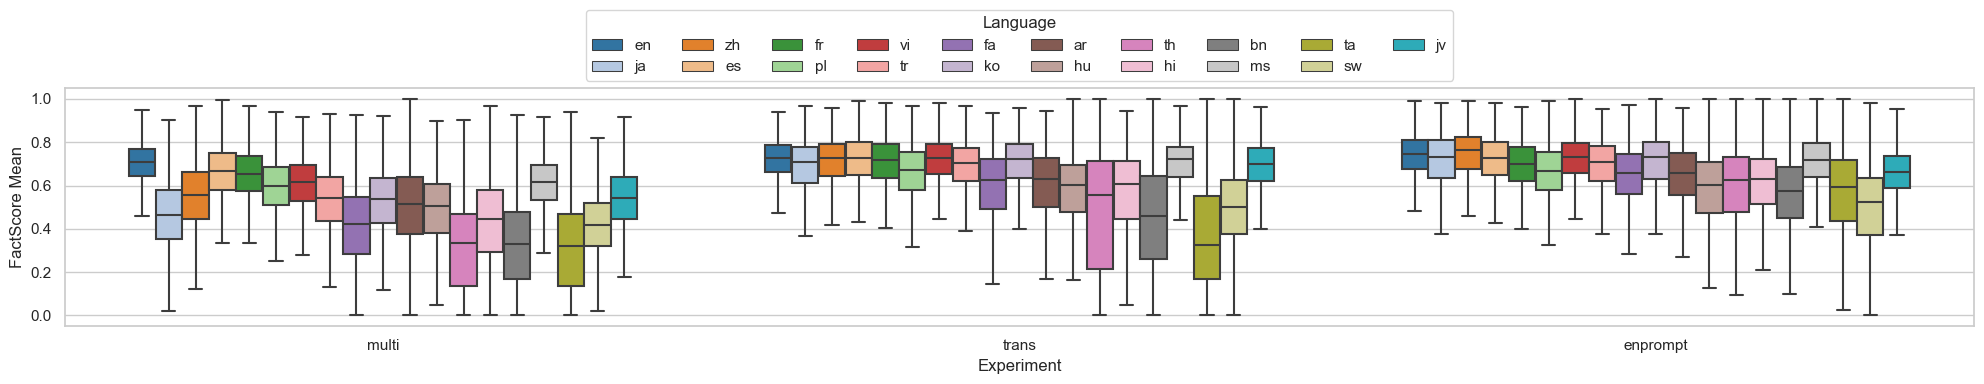

In [53]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(20, 4))
sns.boxplot(x='experiment', y='fs_mean', hue='lang', data=result_df, showfliers=False, hue_order=languages, palette='tab20')
#plt.legend(title='Language', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.legend(title='Language',
    bbox_to_anchor=(0.5, 1),  # Position the legend outside the plot
    loc='lower center',       # Anchor the legend at the top-left corner of the bounding box
    ncol=10                 # Arrange legend items in 2 columns (horizontal)
)
plt.xlabel('Experiment')
plt.ylabel('FactScore Mean')
#plt.title(f'FactScore Mean distribution by Language and Experiment for all models')
tikzplotlib.save(fig_dir+"all_fs.tex")
reformat(fig_dir+"all_fs.tex")
plt.tight_layout()
plt.show()

100%|██████████| 19/19 [03:21<00:00, 10.62s/it]


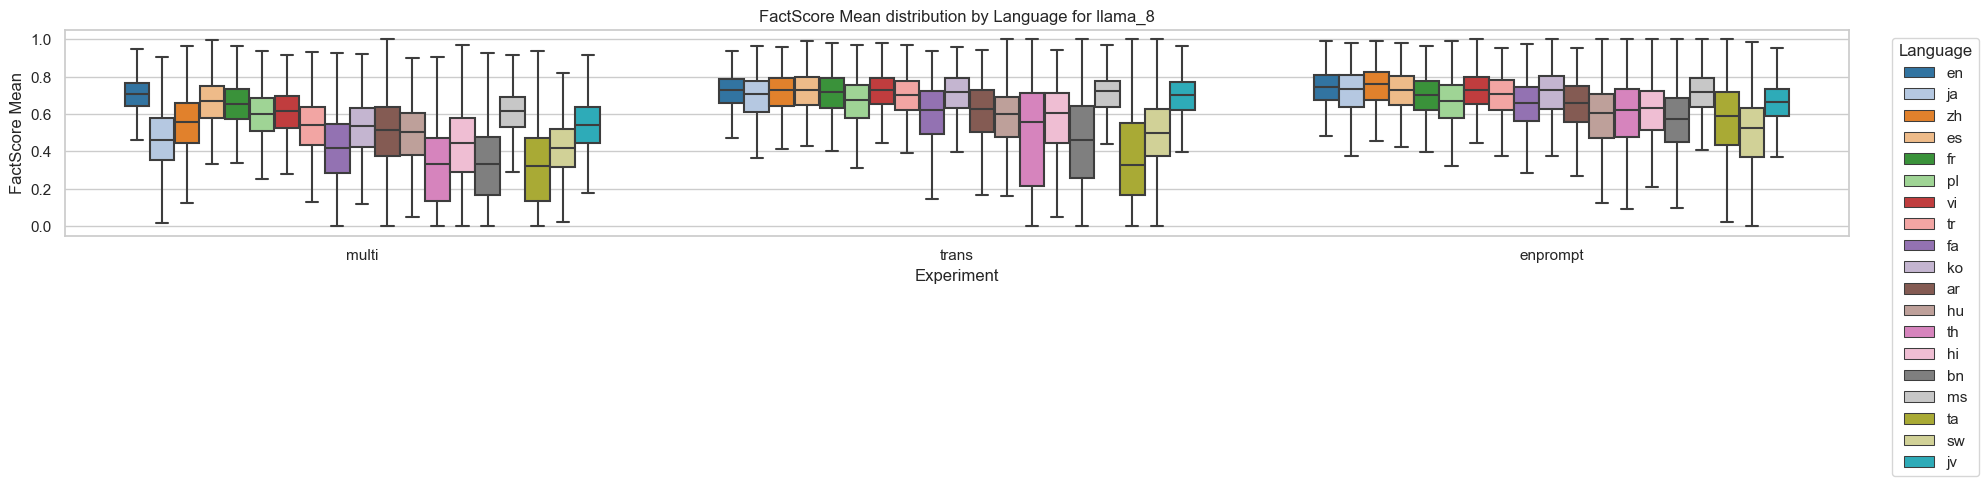

100%|██████████| 19/19 [03:23<00:00, 10.69s/it]


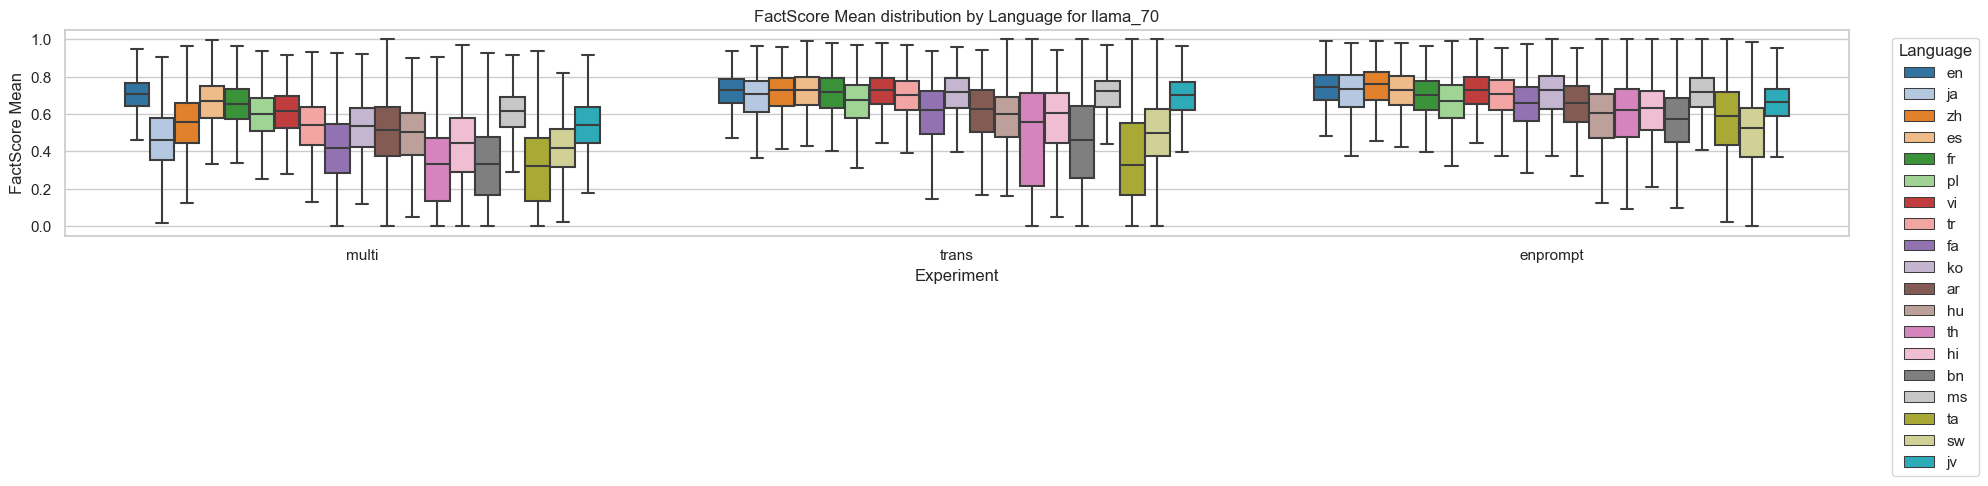

100%|██████████| 19/19 [03:13<00:00, 10.16s/it]


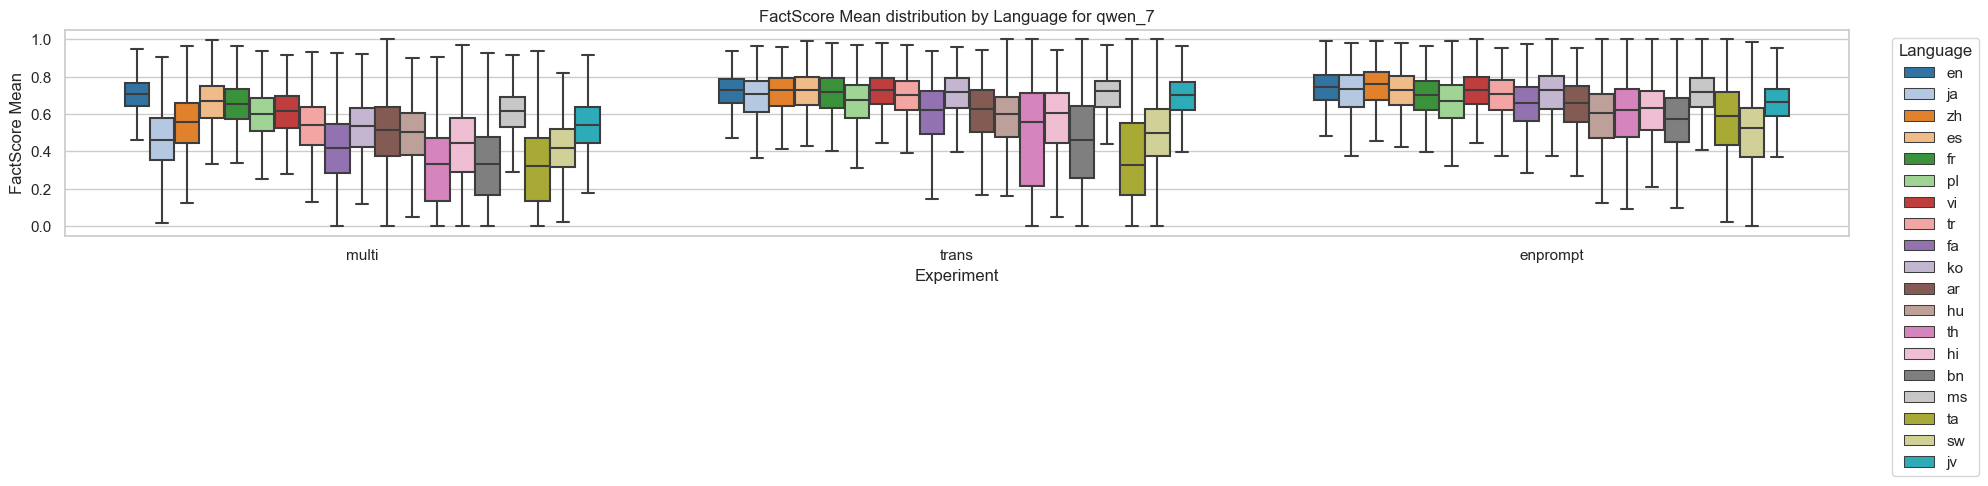

100%|██████████| 19/19 [03:35<00:00, 11.34s/it]


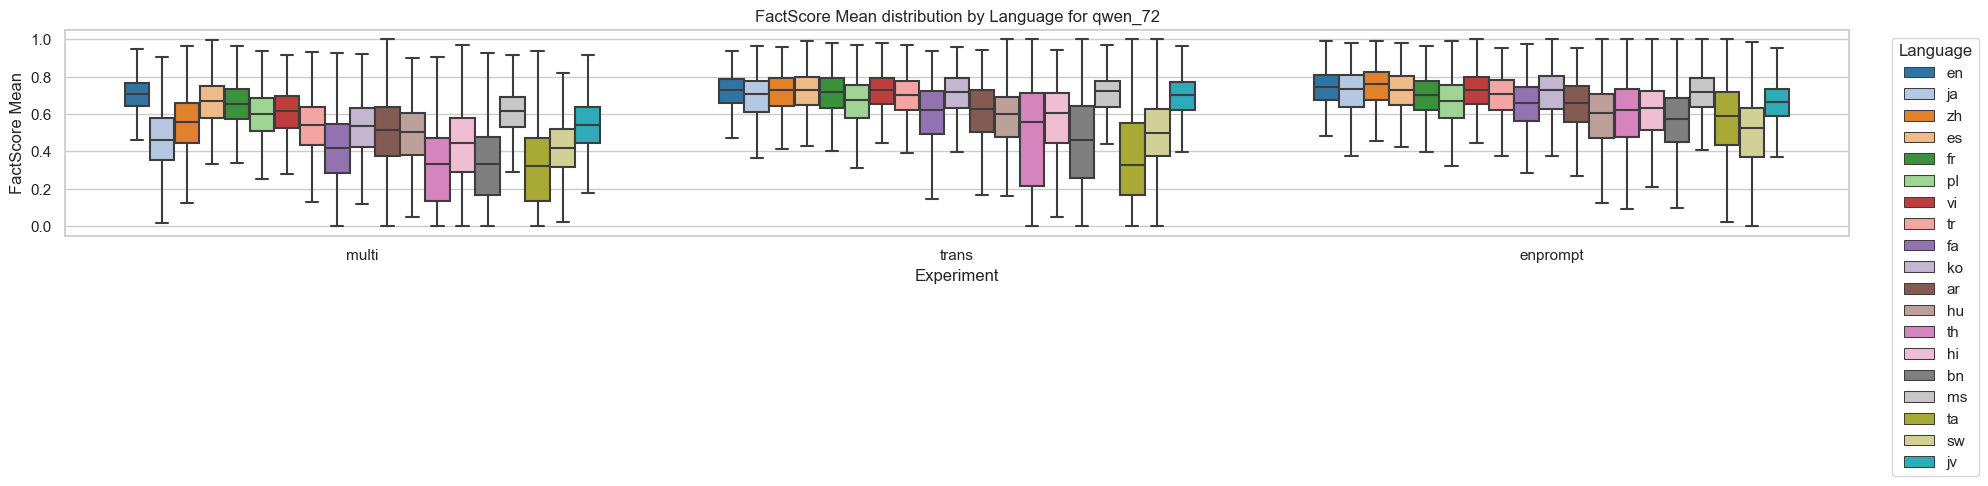

100%|██████████| 19/19 [03:27<00:00, 10.92s/it]


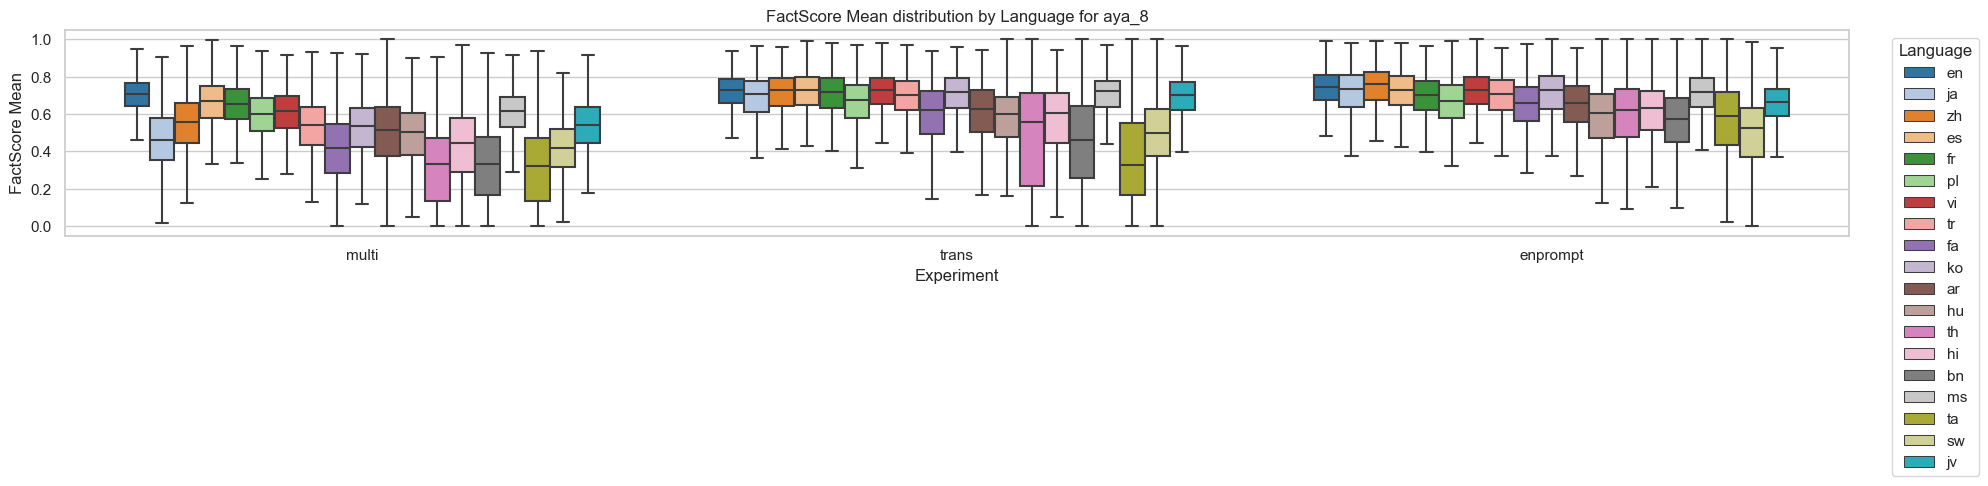

100%|██████████| 19/19 [03:05<00:00,  9.78s/it]


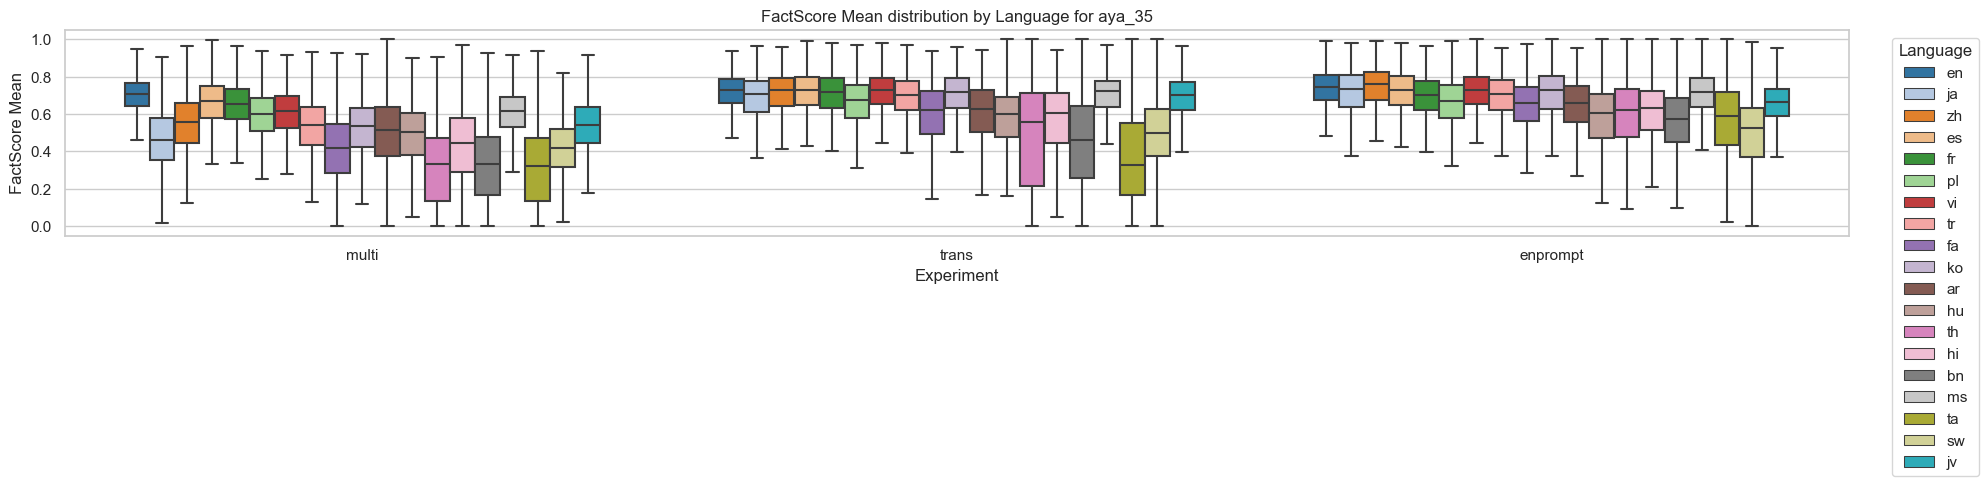

In [54]:
sns.set_theme(style='whitegrid')
for model in models:
    counts = result_df[(result_df.model==model)].groupby(['experiment', 'lang']).size().reset_index(name='count')
    threshold = 0
    valid_experiments_langs = counts[counts['count'] >= threshold]
    filtered_df = result_df.merge(valid_experiments_langs, on=['experiment', 'lang'])
    plt.figure(figsize=(20, 4))
    sns.boxplot(x='experiment', y='fs_mean', hue='lang', data=filtered_df, showfliers=False, hue_order=languages, palette='tab20')
    plt.legend(title='Language', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xlabel('Experiment')
    plt.ylabel('FactScore Mean')
    plt.title(f'FactScore Mean distribution by Language for {model}')
    tikzplotlib.save(fig_dir+f"fs_{model}.tex")
    reformat(fig_dir+f"fs_{model}.tex")
    plt.tight_layout()
    plt.show()

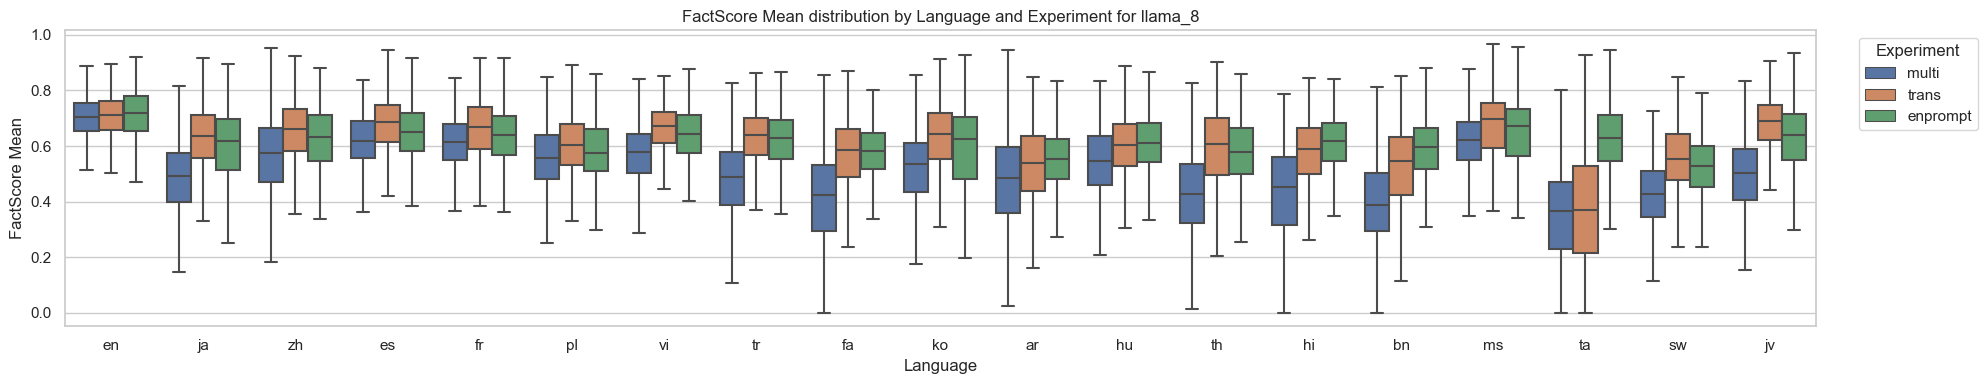

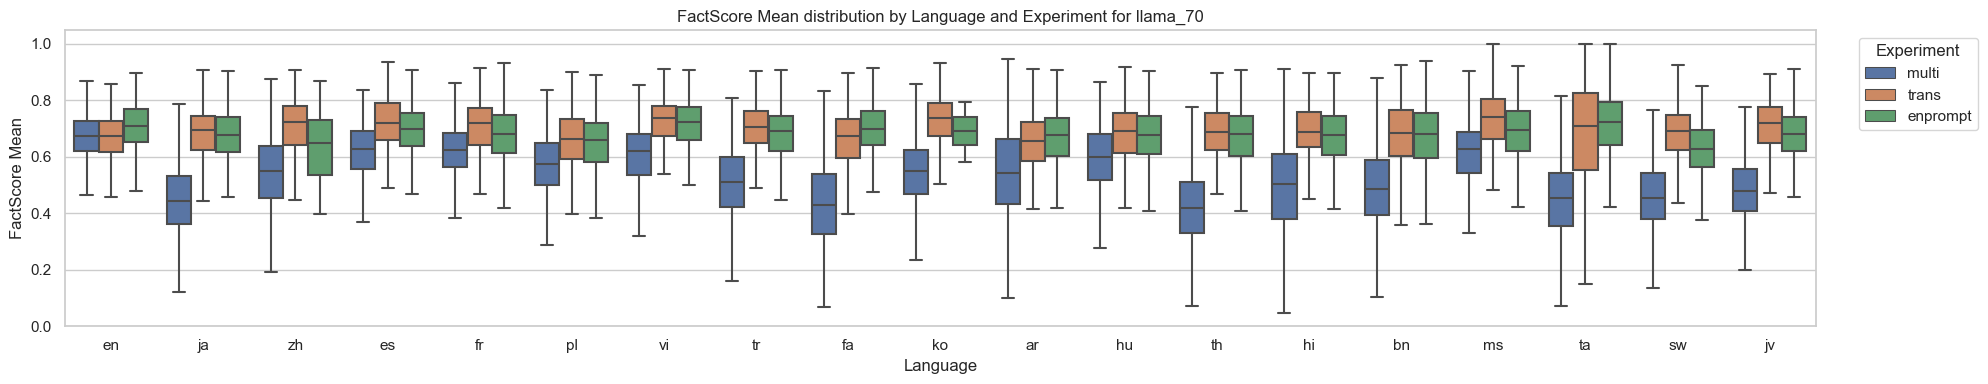

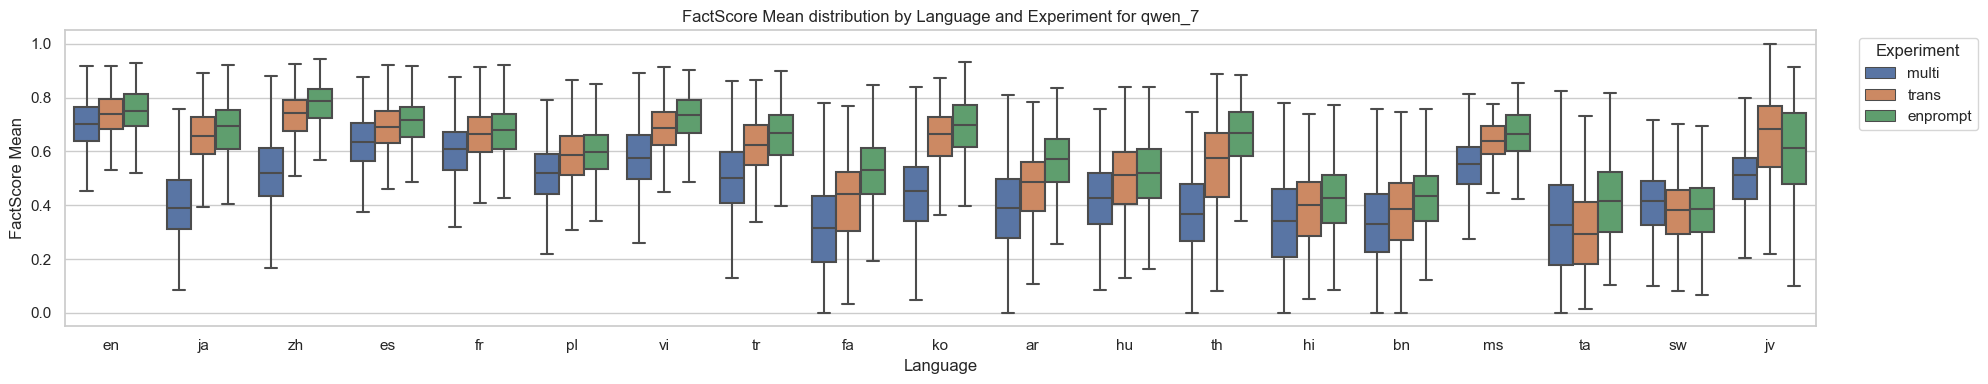

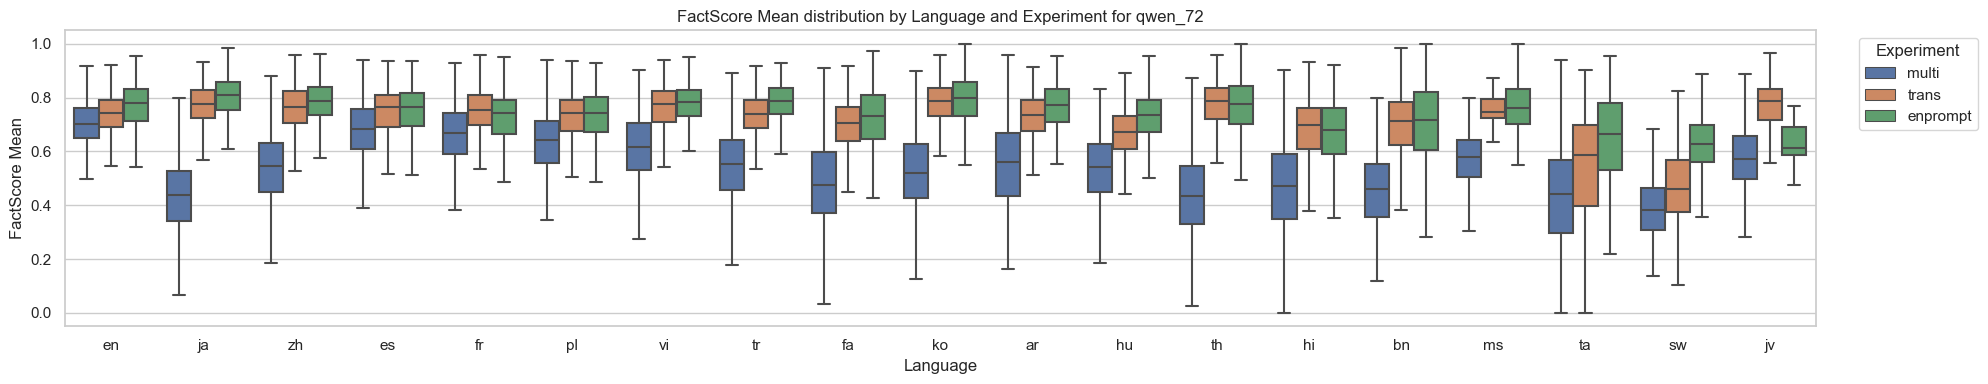

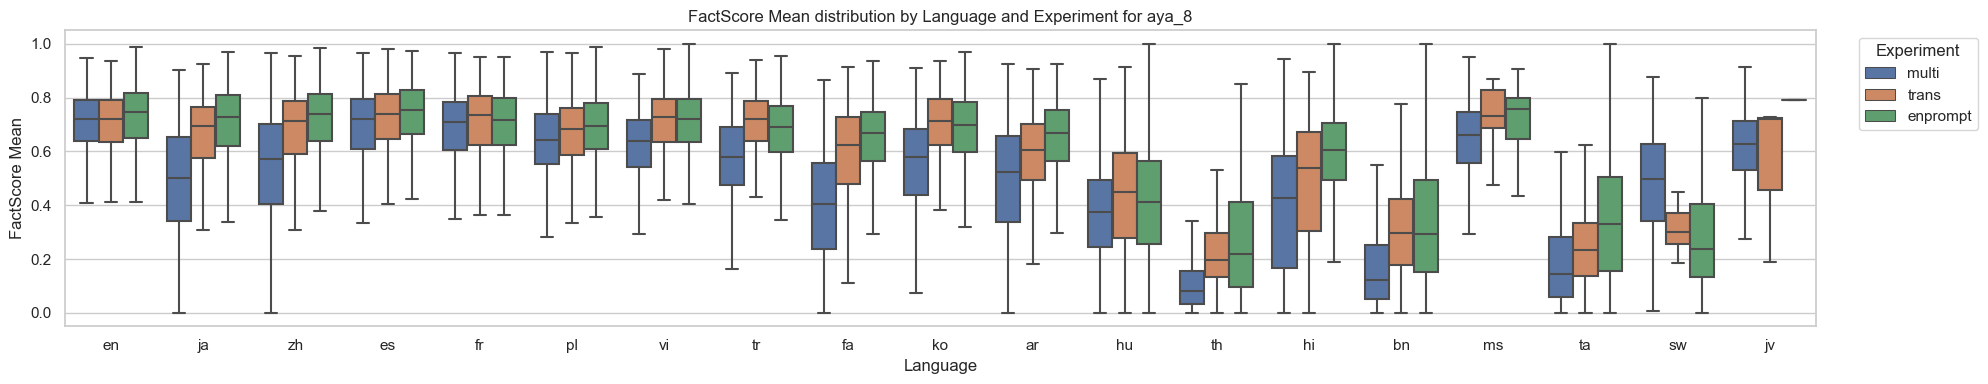

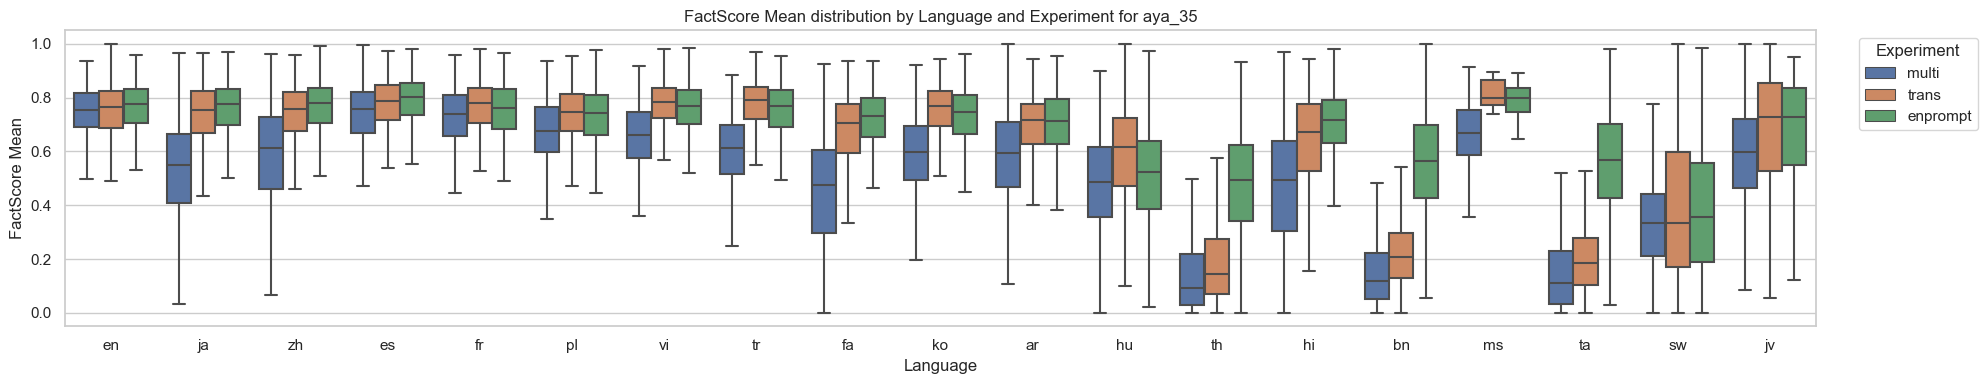

In [32]:
sns.set_theme(style='whitegrid')
for model in models:
    plt.figure(figsize=(20, 4))
    sns.boxplot(x='lang', y='fs_mean', hue='experiment', data=result_df[result_df.model==model], showfliers=False, order=languages)
    plt.legend(title='Experiment', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xlabel('Language')
    plt.ylabel('FactScore Mean')
    plt.title(f'FactScore Mean distribution by Language and Experiment for {model}')
    plt.tight_layout()
    plt.show()

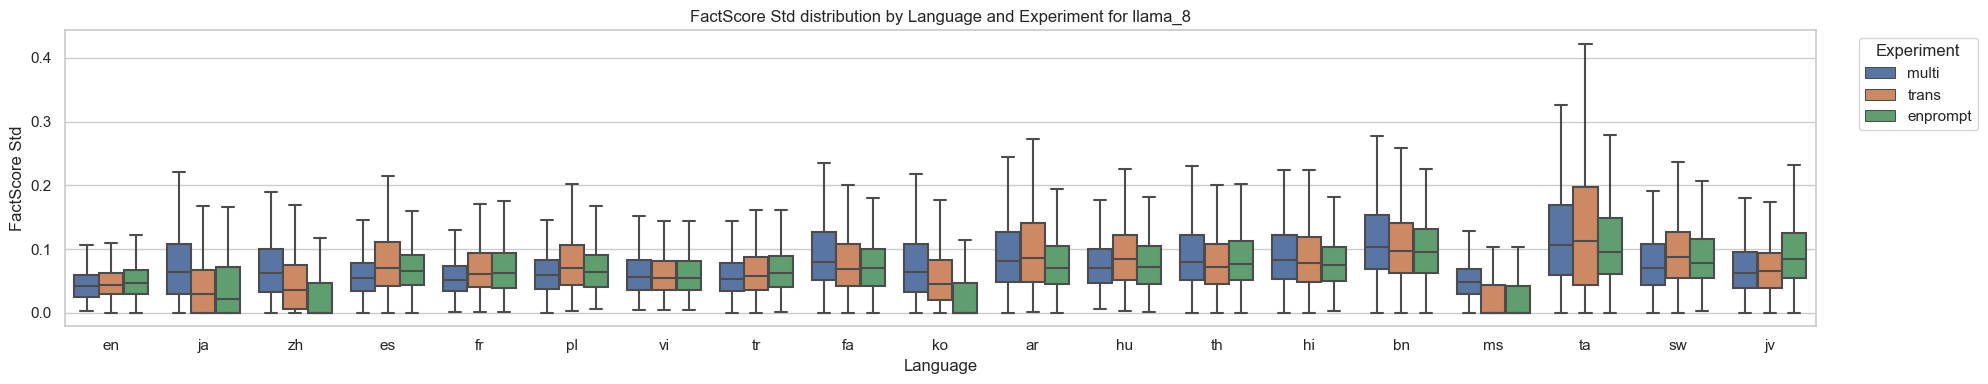

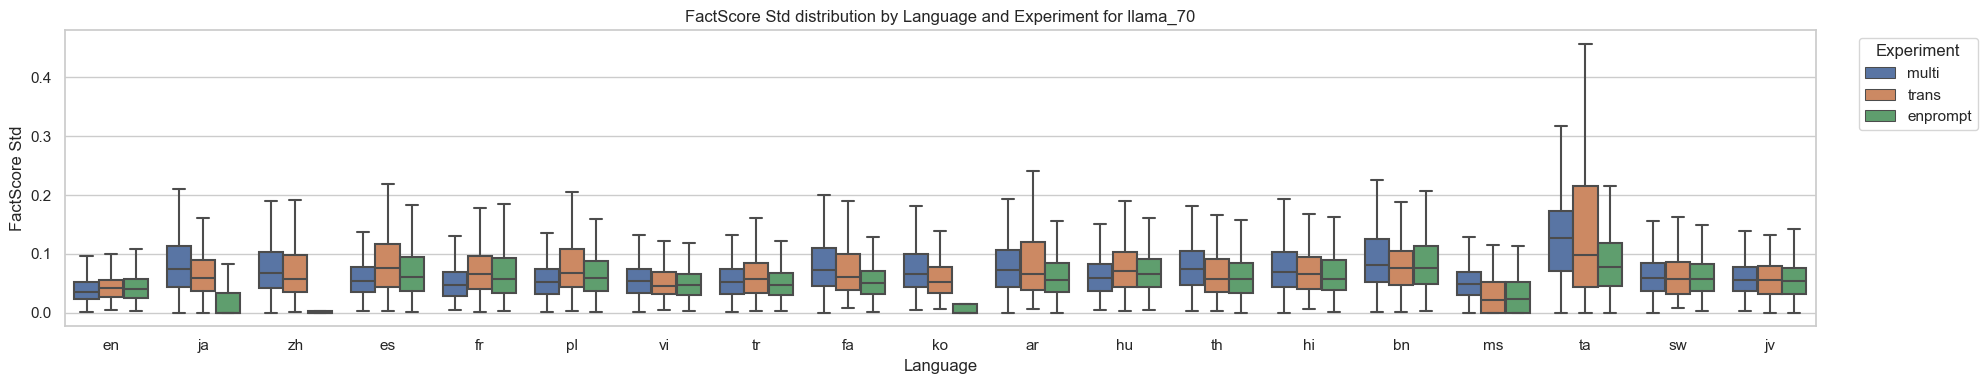

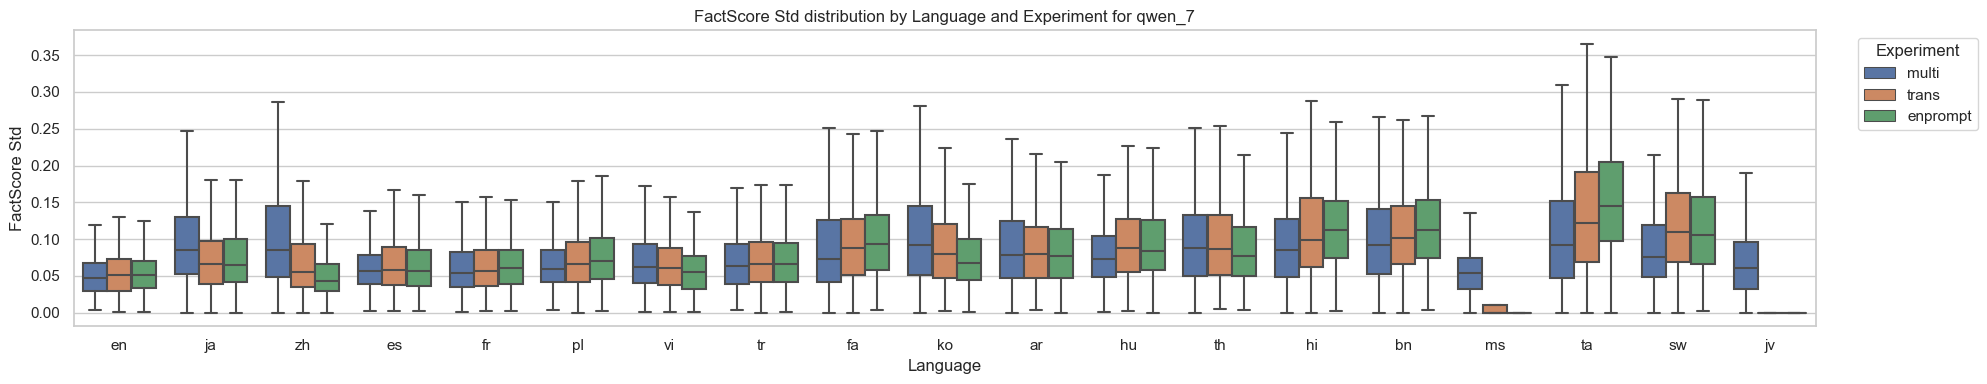

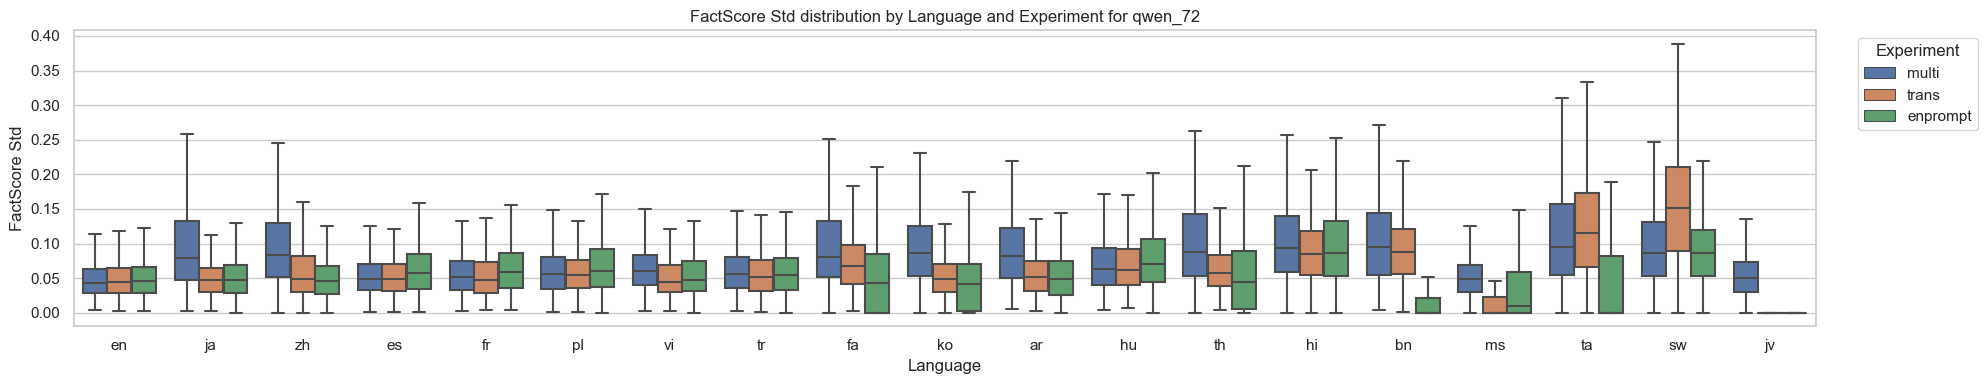

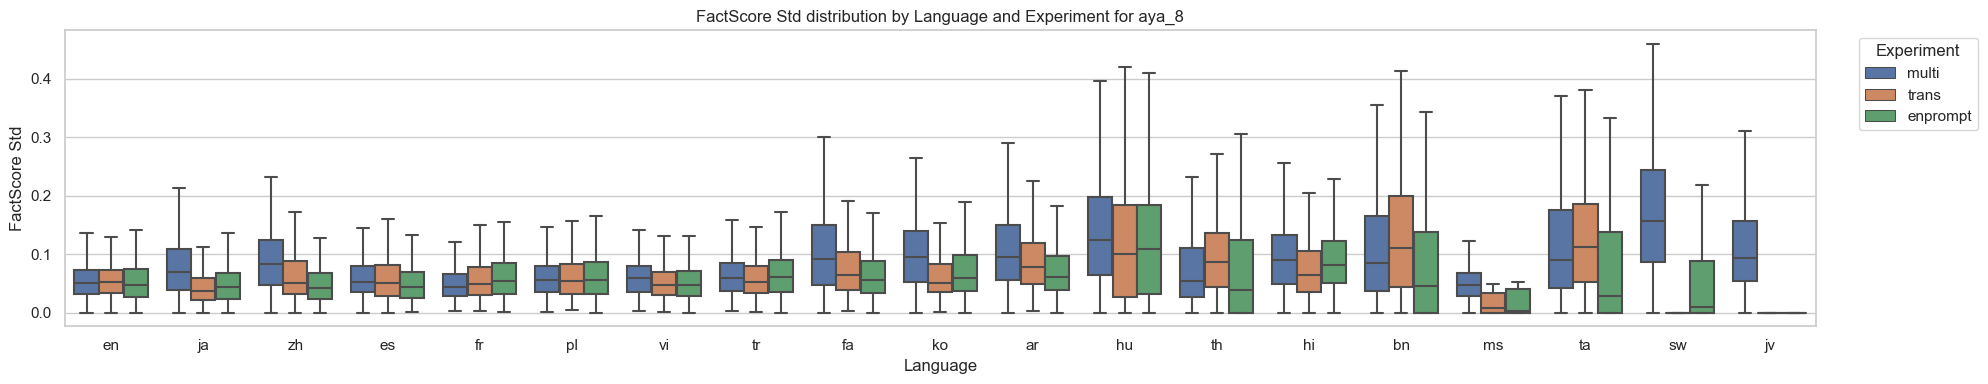

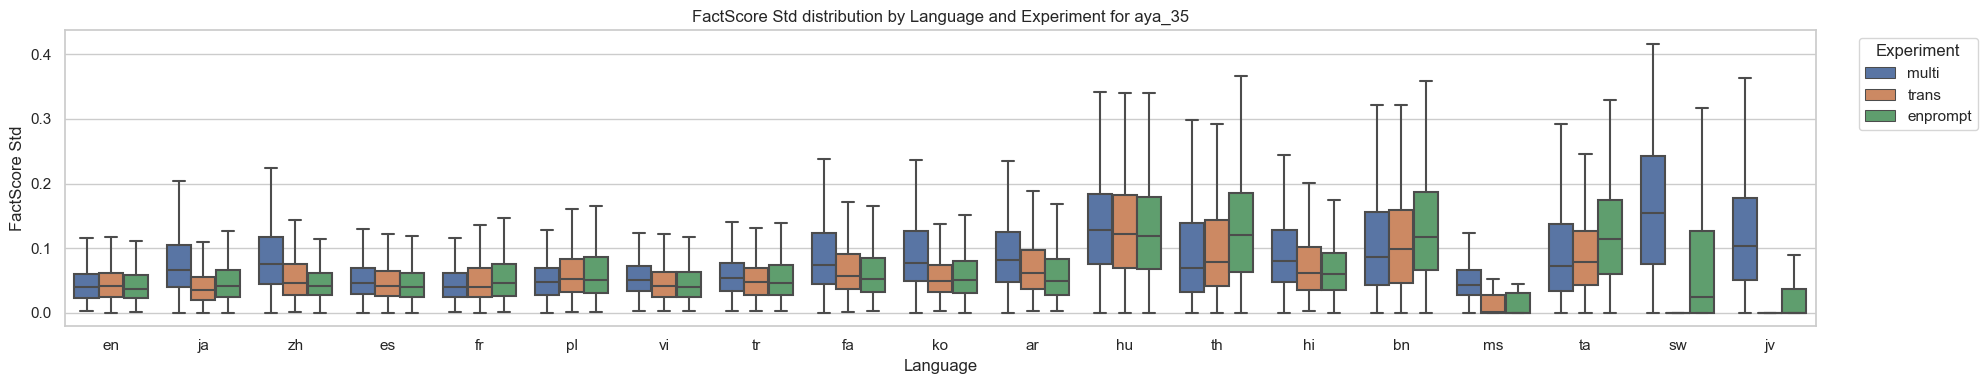

In [33]:
sns.set_theme(style='whitegrid')
for model in models:
    plt.figure(figsize=(20, 4))
    sns.boxplot(x='lang', y='fs_std', hue='experiment', data=result_df[result_df.model==model], showfliers=False, order=languages)
    plt.legend(title='Experiment', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xlabel('Language')
    plt.ylabel('FactScore Std')
    plt.title(f'FactScore Std distribution by Language and Experiment for {model}')
    plt.tight_layout()
    plt.show()

In [13]:
def create_pivot_table(df):
   
    # Create pivot tables for each metric
    fs_mean_pivot = df.pivot_table(index='lang_cat', columns='experiment', values='fs_mean', aggfunc='mean')
    nb_facts_mean_pivot = df.pivot_table(index='lang_cat', columns='experiment', values='nb_facts_mean', aggfunc='mean')
    
    # Convert fs_mean to percentages and round to 1 decimal place
    fs_mean_pivot = (fs_mean_pivot * 100).round(1)
    
    # Round nb_facts_mean to the nearest integer
    nb_facts_mean_pivot = nb_facts_mean_pivot.round(0).astype(int)
    
    # Rename columns for each metric
    fs_mean_pivot.columns = pd.MultiIndex.from_product([['fs_mean'], fs_mean_pivot.columns])
    nb_facts_mean_pivot.columns = pd.MultiIndex.from_product([['nb_facts_mean'], nb_facts_mean_pivot.columns])
    
    # Concatenate the pivot tables along the columns
    combined_pivot = pd.concat([fs_mean_pivot, nb_facts_mean_pivot], axis=1)
    
    # Sort the columns to keep them grouped by metric
    # Create a new MultiIndex with the specified experiment order
    new_columns = pd.MultiIndex.from_product(
        [combined_pivot.columns.levels[0], ['enprompt', 'trans', 'multi']],
        names=combined_pivot.columns.names
    )
    
    # Reindex the columns with the new order
    combined_pivot = combined_pivot.reindex(columns=new_columns)
    
    # Reindex rows for specific order
    combined_pivot = combined_pivot.reindex(['Very-High', 'High', 'Medium', 'Low'])
    
    return combined_pivot


# Example for 'model1'
pivot_table_model1 = create_pivot_table(result_df)
print(pivot_table_model1)

            fs_mean             nb_facts_mean            
experiment enprompt trans multi      enprompt trans multi
lang_cat                                                 
Very-High      73.7  71.8  70.3            79    82   103
High           70.2  69.3  58.5            68    73    65
Medium         64.7  61.3  47.8            54    59    49
Low            56.9  47.6  44.4            38    34    53


In [74]:
print(pivot_table_model1.to_latex())

\begin{tabular}{lllllll}
\toprule
{} & \multicolumn{3}{l}{fs\_mean} & \multicolumn{3}{l}{nb\_facts\_mean} \\
experiment &     enprompt &        trans &        multi &      enprompt &    trans &     multi \\
lang\_cat  &              &              &              &               &          &           \\
\midrule
Very-High &  73.7 ± 10.1 &   71.8 ± 9.9 &   70.3 ± 9.7 &       79 ± 12 &  82 ± 12 &  103 ± 26 \\
High      &  70.2 ± 12.6 &  69.3 ± 13.4 &  58.5 ± 16.4 &       68 ± 15 &  73 ± 17 &   65 ± 36 \\
Medium    &  64.7 ± 16.0 &  61.3 ± 19.5 &  47.8 ± 19.4 &       54 ± 19 &  59 ± 21 &   49 ± 33 \\
Low       &  56.9 ± 18.9 &  47.6 ± 23.4 &  44.4 ± 20.4 &       38 ± 19 &  34 ± 19 &   53 ± 37 \\
\bottomrule
\end{tabular}



In [92]:
def create_pivot_table(df, model=None):
    if model:
        df=df[df.model==model]
    # Create pivot tables for each metric (mean and std)
    fs_mean_pivot = df.pivot_table(index='lang_cat', columns='experiment', values='fs_mean', aggfunc=['mean', 'std'])
    nb_facts_mean_pivot = df.pivot_table(index='lang_cat', columns='experiment', values='nb_facts_mean', aggfunc=['mean', 'std'])
    
    # Convert fs_mean to percentages and round to 1 decimal place
    fs_mean_pivot['mean'] = (fs_mean_pivot['mean'] * 100).round(1)
    fs_mean_pivot['std'] = (fs_mean_pivot['std'] * 100).round(1)
    
    # Round nb_facts_mean to the nearest integer
    nb_facts_mean_pivot['mean'] = nb_facts_mean_pivot['mean'].round(0).astype(int)
    nb_facts_mean_pivot['std'] = nb_facts_mean_pivot['std'].round(0).astype(int)
    
    # Format the results as "mean ± std"
    fs_mean_formatted = fs_mean_pivot.apply(lambda x: x['mean'].astype(str) + ' \small{(± ' + x['std'].astype(str)+')}', axis=1)
    nb_facts_mean_formatted = nb_facts_mean_pivot.apply(lambda x: x['mean'].astype(str), axis=1)
    
    # Rename columns for each metric
    fs_mean_formatted.columns = pd.MultiIndex.from_product([['fs_mean'], fs_mean_formatted.columns])
    nb_facts_mean_formatted.columns = pd.MultiIndex.from_product([['nb_facts_mean'], nb_facts_mean_formatted.columns])
    
    # Concatenate the pivot tables along the columns
    combined_pivot = pd.concat([fs_mean_formatted, nb_facts_mean_formatted], axis=1)
    
    # Sort the columns to keep them grouped by metric
    # Create a new MultiIndex with the specified experiment order
    new_columns = pd.MultiIndex.from_product(
        [combined_pivot.columns.levels[0], ['enprompt', 'trans', 'multi']],
        names=combined_pivot.columns.names
    )
    
    # Reindex the columns with the new order
    combined_pivot = combined_pivot.reindex(columns=new_columns)
    
    # Reindex rows for specific order
    combined_pivot = combined_pivot.reindex(['Very-High', 'High', 'Medium', 'Low'])
    
    return combined_pivot

In [105]:
# Example for 'model1'
pivot_table_model1 = create_pivot_table(result_df, 'qwen_72')
print(pivot_table_model1)

                          fs_mean                         \
experiment               enprompt                  trans   
lang_cat                                                   
Very-High    76.6 \small{(± 8.8)}   73.5 \small{(± 8.3)}   
High         75.8 \small{(± 9.9)}   74.7 \small{(± 9.6)}   
Medium      74.4 \small{(± 11.7)}  72.3 \small{(± 11.3)}   
Low         67.5 \small{(± 13.8)}  57.4 \small{(± 19.7)}   

                                  nb_facts_mean              
experiment                  multi      enprompt trans multi  
lang_cat                                                     
Very-High    70.2 \small{(± 8.5)}            84    86   109  
High        59.3 \small{(± 15.5)}            66    71    62  
Medium      52.2 \small{(± 15.8)}            48    52    49  
Low         48.7 \small{(± 15.8)}            43    29    62  


In [106]:
print(pivot_table_model1.to_latex())

\begin{tabular}{lllllll}
\toprule
{} & \multicolumn{3}{l}{fs\_mean} & \multicolumn{3}{l}{nb\_facts\_mean} \\
experiment &               enprompt &                  trans &                  multi &      enprompt & trans & multi \\
lang\_cat  &                        &                        &                        &               &       &       \\
\midrule
Very-High &   76.6 \textbackslash small\{(± 8.8)\} &   73.5 \textbackslash small\{(± 8.3)\} &   70.2 \textbackslash small\{(± 8.5)\} &            84 &    86 &   109 \\
High      &   75.8 \textbackslash small\{(± 9.9)\} &   74.7 \textbackslash small\{(± 9.6)\} &  59.3 \textbackslash small\{(± 15.5)\} &            66 &    71 &    62 \\
Medium    &  74.4 \textbackslash small\{(± 11.7)\} &  72.3 \textbackslash small\{(± 11.3)\} &  52.2 \textbackslash small\{(± 15.8)\} &            48 &    52 &    49 \\
Low       &  67.5 \textbackslash small\{(± 13.8)\} &  57.4 \textbackslash small\{(± 19.7)\} &  48.7 \textbackslash small\{(± 15.8)\} &  

In [23]:
def create_pivot_table_2(df, model=None):
    if model:
        df=df[df.model==model]
    # Create pivot tables for each metric (mean and std)
    fs_mean_pivot = df.pivot_table(index='lang', columns='experiment', values='fs_mean', aggfunc=['mean', 'std'])
    nb_facts_mean_pivot = df.pivot_table(index='lang', columns='experiment', values='nb_facts_mean', aggfunc=['mean', 'std'])
    
    # Convert fs_mean to percentages and round to 1 decimal place
    fs_mean_pivot['mean'] = (fs_mean_pivot['mean'] * 100).round(1)
    fs_mean_pivot['std'] = (fs_mean_pivot['std'] * 100).round(1)
    
    # Round nb_facts_mean to the nearest integer
    nb_facts_mean_pivot['mean'] = nb_facts_mean_pivot['mean'].round(0).astype(int)
    nb_facts_mean_pivot['std'] = nb_facts_mean_pivot['std'].round(0).astype(int)
    
    # Format the results as "mean ± std"
    fs_mean_formatted = fs_mean_pivot.apply(lambda x: x['mean'].astype(str) + ' \small{(± ' + x['std'].astype(str)+')}', axis=1)
    nb_facts_mean_formatted = nb_facts_mean_pivot.apply(lambda x: x['mean'].astype(str), axis=1)
    
    # Rename columns for each metric
    fs_mean_formatted.columns = pd.MultiIndex.from_product([['fs_mean'], fs_mean_formatted.columns])
    nb_facts_mean_formatted.columns = pd.MultiIndex.from_product([['nb_facts_mean'], nb_facts_mean_formatted.columns])
    
    # Concatenate the pivot tables along the columns
    combined_pivot = pd.concat([fs_mean_formatted, nb_facts_mean_formatted], axis=1)
    
    # Sort the columns to keep them grouped by metric
    # Create a new MultiIndex with the specified experiment order
    new_columns = pd.MultiIndex.from_product(
        [combined_pivot.columns.levels[0], ['enprompt', 'trans', 'multi']],
        names=combined_pivot.columns.names
    )
    
    # Reindex the columns with the new order
    combined_pivot = combined_pivot.reindex(columns=new_columns)
    
    # Reindex rows for specific order
    combined_pivot = combined_pivot.reindex(languages)
    
    return combined_pivot

In [24]:
# Example for 'model1'
pivot_table_model3 = create_pivot_table_2(result_df)
print(pivot_table_model3)

                          fs_mean                         \
experiment               enprompt                  trans   
lang                                                       
en          73.7 \small{(± 10.1)}   71.8 \small{(± 9.9)}   
ja          71.2 \small{(± 13.5)}  68.1 \small{(± 14.6)}   
zh          73.6 \small{(± 12.8)}  69.6 \small{(± 15.2)}   
es          71.8 \small{(± 11.3)}  71.9 \small{(± 11.6)}   
fr          69.4 \small{(± 11.7)}  70.6 \small{(± 11.8)}   
pl          66.1 \small{(± 12.7)}  66.2 \small{(± 12.6)}   
vi          71.8 \small{(± 10.8)}  71.4 \small{(± 11.9)}   
tr          69.5 \small{(± 12.0)}  68.7 \small{(± 12.9)}   
fa          64.5 \small{(± 13.8)}  58.8 \small{(± 18.5)}   
ko          70.7 \small{(± 13.7)}  69.3 \small{(± 14.9)}   
ar          64.9 \small{(± 13.7)}  60.1 \small{(± 17.0)}   
hu          57.8 \small{(± 17.7)}  57.1 \small{(± 17.5)}   
th          58.0 \small{(± 21.1)}  48.5 \small{(± 26.9)}   
hi          61.2 \small{(± 15.6)}  56.3 

In [22]:
for lang in languages:
    # Filter the DataFrame for the two experimental settings (replace 'exp1' and 'exp2' with your actual experiment names)
    df_filtered = result_df[(result_df['model']=='qwen_72')&(result_df['lang']==lang)]

    # Pivot the DataFrame to have one column per experiment
    df_pivot = df_filtered.pivot_table(index='link', columns='experiment', values='fs_mean')

    correlation = df_pivot.corr()

    print(f"Correlation for {lang}: {correlation}")

Correlation for en: experiment  enprompt     multi     trans
experiment                              
enprompt    1.000000  0.651926  0.746506
multi       0.651926  1.000000  0.837068
trans       0.746506  0.837068  1.000000
Correlation for ja: experiment  enprompt     multi     trans
experiment                              
enprompt    1.000000  0.156956  0.406025
multi       0.156956  1.000000  0.348530
trans       0.406025  0.348530  1.000000
Correlation for zh: experiment  enprompt     multi     trans
experiment                              
enprompt    1.000000  0.279522  0.515889
multi       0.279522  1.000000  0.331271
trans       0.515889  0.331271  1.000000
Correlation for es: experiment  enprompt     multi     trans
experiment                              
enprompt    1.000000  0.272771  0.412656
multi       0.272771  1.000000  0.413067
trans       0.412656  0.413067  1.000000
Correlation for fr: experiment  enprompt     multi     trans
experiment                             

## STD across prompt templates

In [15]:
def create_pivot_table(df):
   
    # Create pivot tables for each metric
    fs_mean_pivot = df.pivot_table(index='lang_cat', columns='experiment', values='fs_std', aggfunc='mean')
    nb_facts_mean_pivot = df.pivot_table(index='lang_cat', columns='experiment', values='nb_facts_std', aggfunc='mean')
    
    # Convert fs_mean to percentages and round to 1 decimal place
    fs_mean_pivot = (fs_mean_pivot * 100).round(1)
    
    # Round nb_facts_mean to the nearest integer
    nb_facts_mean_pivot = nb_facts_mean_pivot.round(0).astype(int)
    
    # Rename columns for each metric
    fs_mean_pivot.columns = pd.MultiIndex.from_product([['fs_std'], fs_mean_pivot.columns])
    nb_facts_mean_pivot.columns = pd.MultiIndex.from_product([['nb_facts_std'], nb_facts_mean_pivot.columns])
    
    # Concatenate the pivot tables along the columns
    combined_pivot = pd.concat([fs_mean_pivot, nb_facts_mean_pivot], axis=1)
    
    # Sort the columns to keep them grouped by metric
    # Create a new MultiIndex with the specified experiment order
    new_columns = pd.MultiIndex.from_product(
        [combined_pivot.columns.levels[0], ['enprompt', 'trans', 'multi']],
        names=combined_pivot.columns.names
    )
    
    # Reindex the columns with the new order
    combined_pivot = combined_pivot.reindex(columns=new_columns)
    
    # Reindex rows for specific order
    combined_pivot = combined_pivot.reindex(['Very-High', 'High', 'Medium', 'Low'])
    
    return combined_pivot


# Example for 'model1'
pivot_table_model2 = create_pivot_table(result_df)
print(pivot_table_model2)

             fs_std             nb_facts_std            
experiment enprompt trans multi     enprompt trans multi
lang_cat                                                
Very-High       4.9   5.1   4.8            7     8     9
High            6.2   6.6   7.0           10    12     8
Medium          7.5   8.0   8.6            8     8     8
Low             8.8  10.2   9.3            5     6    10


In [16]:
print(pivot_table_model2.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{fs\_std} & \multicolumn{3}{l}{nb\_facts\_std} \\
experiment & enprompt & trans & multi &     enprompt & trans & multi \\
lang\_cat  &          &       &       &              &       &       \\
\midrule
Very-High &      4.9 &   5.1 &   4.8 &            7 &     8 &     9 \\
High      &      6.2 &   6.6 &   7.0 &           10 &    12 &     8 \\
Medium    &      7.5 &   8.0 &   8.6 &            8 &     8 &     8 \\
Low       &      8.8 &  10.2 &   9.3 &            5 &     6 &    10 \\
\bottomrule
\end{tabular}



## Factscores per LM subject

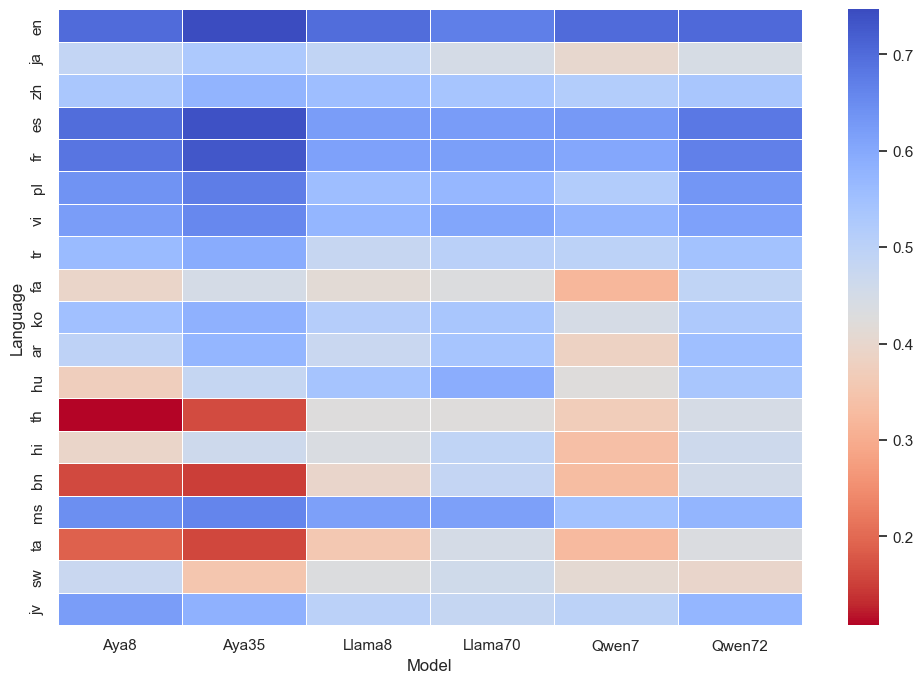

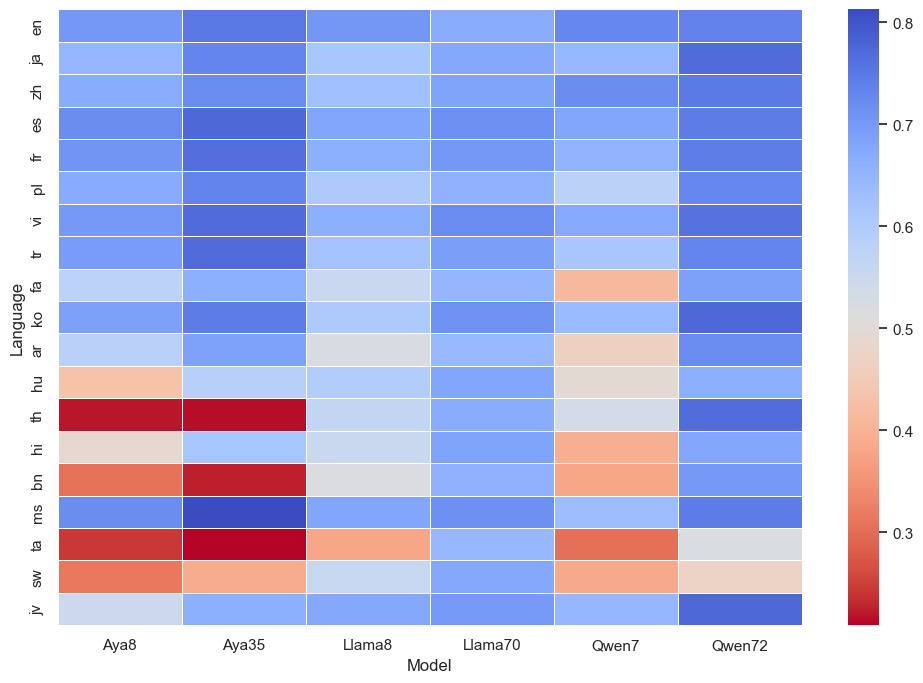

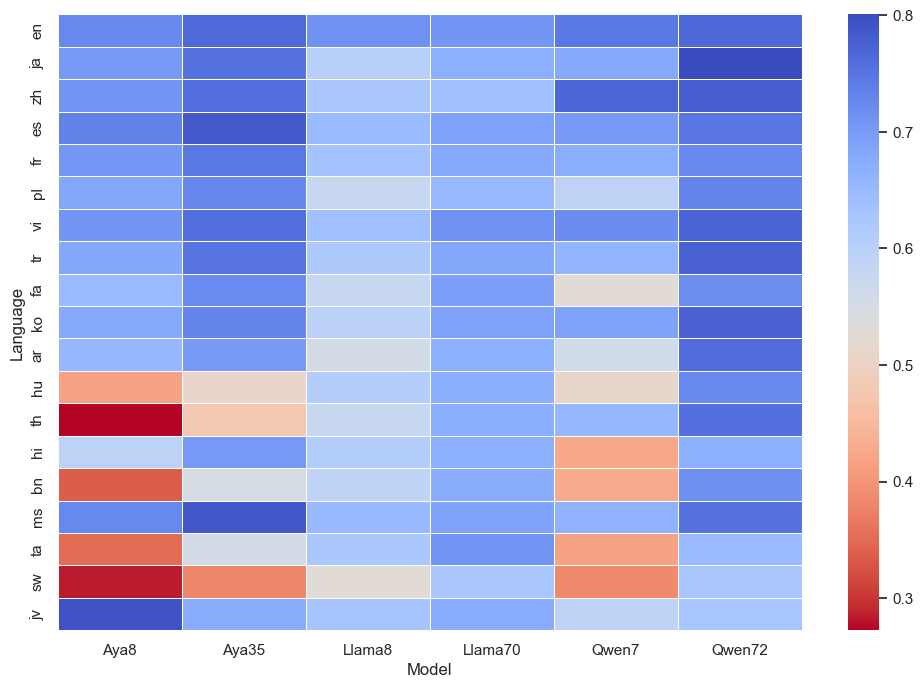

In [203]:
for exp in experiments:
    aggregated_df=result_df[result_df.experiment==exp].groupby(['model', 'lang']).agg({'fs_mean':np.mean})
    aggregated_df = aggregated_df.reset_index()
    pivoted_df = aggregated_df.pivot_table(
        index='lang',
        columns='model',
        values='fs_mean'
    )
    pivoted_df=pivoted_df.reindex(languages)
    pivoted_df=pivoted_df[['aya_8', 'aya_35', 'llama_8', 'llama_70', 'qwen_7', 'qwen_72']]
    pivoted_df.columns=['Aya8', 'Aya35', 'Llama8', 'Llama70', 'Qwen7', 'Qwen72']
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivoted_df, cmap="coolwarm_r", linewidths=.5)
    #plt.title(f'Heatmap of FactScores across models and languages for experiment {exp}')
    plt.xlabel('Model')
    plt.ylabel('Language')
    tikzplotlib.save(fig_dir+f"fs_exp_{exp}.tex")
    plt.show()


## Individual factscores (gender, country,..)

In [14]:
fs_gender_df=result_df.merge(pers_df[['link', 'gender']])
fs_gender_df[(fs_gender_df.lang=='en')&(fs_gender_df.experiment=='enprompt')].groupby(['model', 'gender']).agg({'fs_mean': np.mean})

fs_mean
model    gender               
aya_35   female       0.779572
         genderfluid  0.702865
         male         0.761159
         non-binary   0.835831
aya_8    female       0.718618
         genderfluid  0.761294
         male         0.726588
         non-binary   0.751413
llama_70 female       0.754674
         genderfluid  0.688379
         male         0.698869
         non-binary   0.805050
llama_8  female       0.752677
         genderfluid  0.800325
         male         0.704467
         non-binary   0.822809
qwen_7   female       0.773937
         genderfluid  0.854835
         male         0.741245
         non-binary   0.877167
qwen_72  female       0.801903
         genderfluid  0.864314
         male         0.759169
         non-binary   0.881596

In [15]:
fs_city_df=result_df.merge(pers_df[['link', 'citizenship']])

In [16]:
fs_city_df

,link,experiment,lang,model,fs_mean,fs_std,nb_facts_mean,nb_facts_std,init_score,respond_ratio,ent_mean,ent_std,con_mean,con_std,diff_mean,diff_std,lang_cat,citizenship
0,http://www.wikidata.org/entity/Q34981,multi,en,llama_8,0.805515,0.018318,80.666667,5.557777,0.805515,1.0,0.088432,0.046377,0.222895,0.066492,-0.134463,0.064790,Very-High,Russia
1,http://www.wikidata.org/entity/Q34981,multi,ja,llama_8,0.643056,0.160162,16.333333,1.247219,0.643056,1.0,0.148739,0.120353,0.005414,0.002506,0.143324,0.117847,High,Russia
2,http://www.wikidata.org/entity/Q34981,multi,zh,llama_8,0.606250,0.043750,18.000000,2.000000,0.606250,1.0,0.006096,0.004717,0.000933,0.000362,0.005163,0.004402,High,Russia
3,http://www.wikidata.org/entity/Q34981,multi,es,llama_8,0.681369,0.054873,56.666667,1.247219,0.681369,1.0,0.083637,0.025716,0.047895,0.048867,0.035742,0.070843,High,Russia
4,http://www.wikidata.org/entity/Q34981,multi,fr,llama_8,0.681128,0.020096,63.000000,6.164414,0.681128,1.0,0.029799,0.038571,0.238162,0.070117,-0.208363,0.063594,High,Russia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149563,http://www.wikidata.org/entity/Q92764,enprompt,hi,aya_35,0.624476,0.087774,34.000000,3.741657,0.624476,1.0,0.015677,0.003164,0.551582,0.047117,-0.535905,0.046813,Medium,United States
149564,http://www.wikidata.org/entity/Q92764,enprompt,bn,aya_35,0.303158,0.144667,21.000000,2.828427,0.303158,1.0,0.028390,0.027326,0.678886,0.171186,-0.650495,0.154991,Low,United States
149565,http://www.wikidata.org/entity/Q92764,enprompt,ta,aya_35,0.678707,0.200594,19.666667,6.944222,0.678707,1.0,0.296747,0.052306,0.509763,0.270069,-0.213016,0.217928,Low,United States
149566,http://www.wikidata.org/entity/Q92764,enprompt,sw,aya_35,0.113924,0.000000,79.000000,0.000000,0.113924,1.0,0.009089,0.000000,0.737119,0.000000,-0.728030,0.000000,Low,United States


In [17]:
fs_city_df[fs_city_df.citizenship=='Barbados']

,link,experiment,lang,model,fs_mean,fs_std,nb_facts_mean,nb_facts_std,init_score,respond_ratio,ent_mean,ent_std,con_mean,con_std,diff_mean,diff_std,lang_cat,citizenship
6911,http://www.wikidata.org/entity/Q36844,multi,en,llama_8,0.821119,0.023606,96.666667,2.054805,0.821119,1.0,0.202091,0.006299,0.290675,0.097807,-0.088584,0.093540,Very-High,Barbados
6912,http://www.wikidata.org/entity/Q36844,multi,ja,llama_8,0.626359,0.061141,19.500000,3.500000,0.626359,1.0,0.327309,0.197555,0.039288,0.046670,0.288021,0.186949,High,Barbados
6913,http://www.wikidata.org/entity/Q36844,multi,zh,llama_8,0.856410,0.010256,14.000000,1.000000,0.856410,1.0,0.007970,0.005391,0.001231,0.000576,0.006739,0.004817,High,Barbados
6914,http://www.wikidata.org/entity/Q36844,multi,es,llama_8,0.819613,0.021359,67.000000,4.320494,0.819613,1.0,0.372079,0.014951,0.349752,0.106063,0.022327,0.114819,High,Barbados
6915,http://www.wikidata.org/entity/Q36844,multi,fr,llama_8,0.838575,0.054137,82.333333,5.792716,0.838575,1.0,0.195113,0.019425,0.408853,0.027776,-0.213740,0.034336,High,Barbados
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7217,http://www.wikidata.org/entity/Q36844,enprompt,th,aya_35,0.557668,0.188823,11.333333,2.494438,0.585317,1.0,0.187310,0.217605,0.300551,0.201408,-0.113241,0.027633,Medium,Barbados
7218,http://www.wikidata.org/entity/Q36844,enprompt,hi,aya_35,0.738453,0.014826,50.000000,5.715476,0.738453,1.0,0.431372,0.018679,0.541972,0.194829,-0.110600,0.177818,Medium,Barbados
7219,http://www.wikidata.org/entity/Q36844,enprompt,bn,aya_35,0.401463,0.035099,21.333333,3.091206,0.401463,1.0,0.156080,0.017779,0.458504,0.052950,-0.302424,0.067314,Low,Barbados
7220,http://www.wikidata.org/entity/Q36844,enprompt,ta,aya_35,0.427003,0.351238,22.000000,0.816497,0.427003,1.0,0.188720,0.260955,0.642889,0.200283,-0.454170,0.461239,Low,Barbados


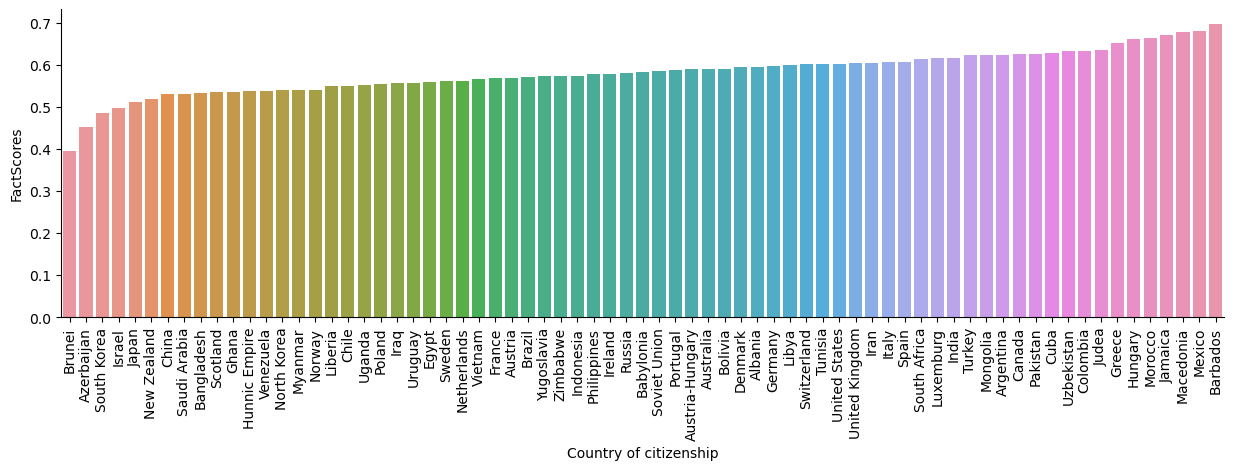

In [21]:
fig,ax=plt.subplots(figsize=(15,4))
data=fs_city_df.groupby('citizenship', as_index=False).agg({'fs_mean':np.mean})
data=data.sort_values(by='fs_mean')
sns.barplot(x=data.citizenship, y=data.fs_mean)
sns.despine(bottom = False, left = False)
plt.xticks(rotation=90)
plt.xlabel('Country of citizenship')
plt.ylabel('FactScores')
plt.show()

In [28]:
pers_df[pers_df.citizenship=='Canada']

,code,name,instance,citizenship,language,birth_place,birth_date,death_date,gender,occupation,birth_year,death_year,is_dead,link
303,Q34086,Justin_Bieber,human,Canada,"['Canadian English', 'English']",London,1994-03-01,NaN,male,artist,1994.0,NaN,False,http://www.wikidata.org/entity/Q34086
422,Q43416,Keanu_Reeves,human,Canada,['English'],Beirut,1964-09-02,NaN,male,actor,1964.0,NaN,False,http://www.wikidata.org/entity/Q43416


In [12]:
fs_city_df.loc[fs_city_df.lang=='zh', ['citizenship', 'fs_mean']]

,citizenship,fs_mean
2,Russia,0.606250
21,Russia,0.491053
40,Russia,0.546855
59,Russia,0.552117
78,Russia,0.761905
...,...,...
149470,United States,0.512821
149504,United States,0.696129
149522,United States,0.790480
149537,United States,0.863626


In [ ]:
# Count the number of people per country
for lang in languages:
    print(f"FactScore by Country of Citizenship for lang {lang}")
    country_fs =fs_city_df[(fs_city_df.experiment=='enprompt')&
                           (fs_city_df.model=='qwen_72')&
                           (fs_city_df.lang==lang)]\
                            .groupby('citizenship', as_index=False).agg({'fs_mean':np.mean})
    country_fs.columns = ['Country', 'FactScore']
    # Create the map visualization
    fig = px.choropleth(country_fs, 
                        locations='Country', 
                        locationmode='country names', 
                        color='FactScore', 
                        hover_name='Country',
                        #title=f"FactScore by Country of Citizenship for lang {lang}",
                        color_continuous_scale=px.colors.sequential.Bluered_r)

    fig.update_layout(
        margin=dict(l=20, r=20, t=40, b=20),
        width=800,  # Adjust width for exporting
        height=400)
    
    fig.update_coloraxes(
        colorbar_title='',
        colorbar_title_font=dict(size=16),  # Title font size
        colorbar_tickfont=dict(size=20)     # Tick font size
    )

    fig.show()
    fig.write_image(fig_dir+f"fs_citizenship_{lang}.png", width=800, height=400, scale=3)

In [15]:
page_norm=page_views_df.copy()
page_norm.iloc[:, 2:21]= page_norm.iloc[:, 2:21].div(page_norm.iloc[:, 2:21].sum(axis=0), axis=1) * 100
page_norm
views_lang = pd.melt(page_norm.drop(columns=['name']), id_vars=['link'], var_name='lang', value_name='page_views')
print(views_lang)

                                       link lang  page_views
0       http://www.wikidata.org/entity/Q302   en    0.436922
1       http://www.wikidata.org/entity/Q303   en    0.703067
2       http://www.wikidata.org/entity/Q307   en    0.145877
3       http://www.wikidata.org/entity/Q329   en    0.051333
4       http://www.wikidata.org/entity/Q352   en    0.706326
...                                     ...  ...         ...
9229  http://www.wikidata.org/entity/Q83338   jv    0.240381
9230  http://www.wikidata.org/entity/Q83488   jv    0.176330
9231  http://www.wikidata.org/entity/Q83492   jv    0.134244
9232  http://www.wikidata.org/entity/Q84405   jv    0.092466
9233  http://www.wikidata.org/entity/Q92764   jv    0.198295

[9234 rows x 3 columns]


In [84]:
fs_views=result_df.merge(views_lang, on=['link', 'lang'])

In [80]:
views_lang

,link,lang,page_views
0,http://www.wikidata.org/entity/Q302,en,6595674.0
1,http://www.wikidata.org/entity/Q303,en,10613337.0
2,http://www.wikidata.org/entity/Q307,en,2202124.0
3,http://www.wikidata.org/entity/Q329,en,774913.0
4,http://www.wikidata.org/entity/Q352,en,10662537.0
...,...,...,...
9229,http://www.wikidata.org/entity/Q83338,jv,1565.0
9230,http://www.wikidata.org/entity/Q83488,jv,1148.0
9231,http://www.wikidata.org/entity/Q83492,jv,874.0
9232,http://www.wikidata.org/entity/Q84405,jv,602.0


Correlation for jv: 0.10304665136010846


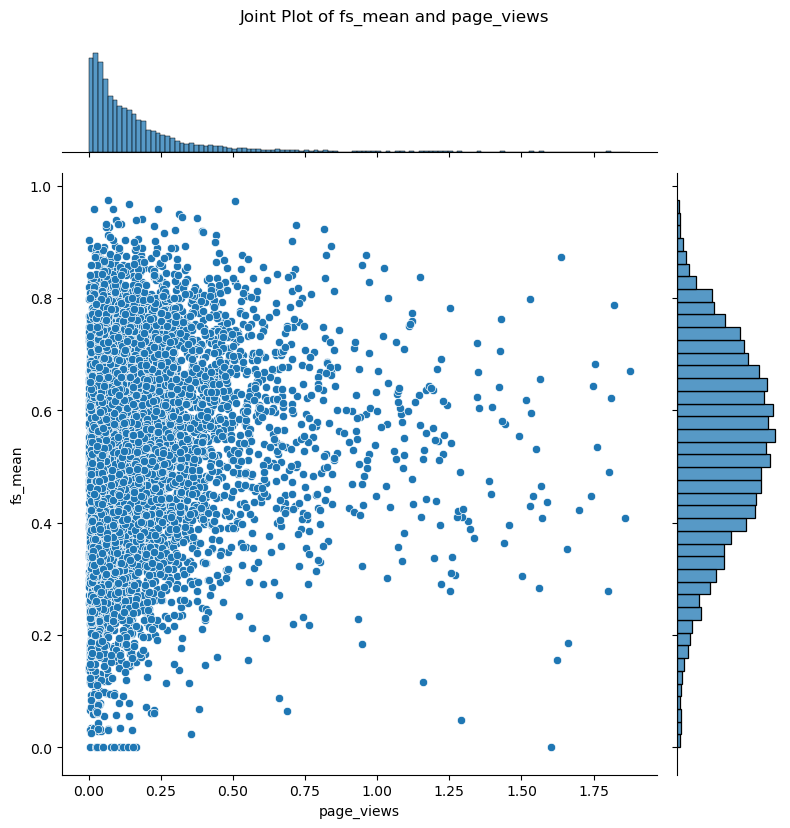

In [91]:
filtered_df = fs_views[(fs_views['experiment'] == 'multi') & (fs_views['model'] == 'qwen_72')]
z_scores = stats.zscore(filtered_df['page_views'])
filtered_df = filtered_df[(abs(z_scores) < 3)]
# Compute the Pearson correlation coefficient between fs_mean and page_views
correlation = filtered_df['fs_mean'].corr(filtered_df['page_views'])
print(f"Correlation for {lang}: {correlation}")

# Create a joint plot comparing 'fs_mean' and 'page_views'
sns.jointplot(y='fs_mean', x='page_views', data=filtered_df, kind='scatter', height=8)

# Add titles
plt.suptitle(f'Joint Plot of fs_mean and page_views', y=1.03)
plt.show()

In [ ]:
for lang in languages:
    filtered_df = fs_views[(fs_views['experiment'] == 'multi') & (fs_views['model'] == 'qwen_72') &(fs_views['lang'] == lang)]
    if len(filtered_df)>1:
        z_scores = stats.zscore(filtered_df['page_views'])
        filtered_df = filtered_df[(abs(z_scores) < 3)]
        
        # Compute the Pearson correlation coefficient between fs_mean and page_views
        correlation = filtered_df['fs_mean'].corr(filtered_df['page_views'])
        print(f"Correlation for {lang}: {correlation}")

        # Create a joint plot comparing 'fs_mean' and 'page_views'
        sns.jointplot(y='fs_mean', x='page_views', data=filtered_df, kind='scatter', height=8)

        # Add titles
        plt.suptitle(f'Joint Plot of fs_mean and page_views for {lang}', y=1.03)
        plt.show()

In [31]:
fs_name_df=result_df.merge(pers_df[['link', 'name']])
fs_name_df['name'] = fs_name_df['name'].apply(urllib.parse.unquote)
fs_name_df['name'] = fs_name_df['name'].str.replace('_', ' ')

In [45]:
fs_name_df[fs_name_df.name=='Cleopatra']

,link,experiment,lang,model,fs_mean,fs_std,nb_facts_mean,nb_facts_std,init_score,respond_ratio,ent_mean,ent_std,con_mean,con_std,diff_mean,diff_std,lang_cat,name
104109,http://www.wikidata.org/entity/Q635,multi,en,llama_8,0.669375,0.061849,82.000000,7.257180,0.669375,1.0,0.322802,0.073498,0.717472,0.075100,-0.394669,0.086165,Very-High,Cleopatra
104110,http://www.wikidata.org/entity/Q635,multi,ja,llama_8,0.623737,0.012626,20.000000,2.000000,0.623737,1.0,0.075591,0.062504,0.023614,0.016436,0.051977,0.046105,High,Cleopatra
104111,http://www.wikidata.org/entity/Q635,multi,zh,llama_8,0.684211,0.000000,19.000000,0.000000,0.684211,1.0,0.005762,0.000675,0.553598,0.138682,-0.547836,0.139347,High,Cleopatra
104112,http://www.wikidata.org/entity/Q635,multi,es,llama_8,0.756671,0.030256,50.000000,6.480741,0.756671,1.0,0.161818,0.093857,0.785826,0.062612,-0.624008,0.156469,High,Cleopatra
104113,http://www.wikidata.org/entity/Q635,multi,fr,llama_8,0.587885,0.058436,95.666667,14.383633,0.587885,1.0,0.223646,0.044841,0.603867,0.029484,-0.380220,0.071728,High,Cleopatra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104413,http://www.wikidata.org/entity/Q635,enprompt,th,aya_35,0.502564,0.035897,14.000000,1.000000,0.502564,1.0,0.152823,0.151859,0.913627,0.067348,-0.760804,0.219207,Medium,Cleopatra
104414,http://www.wikidata.org/entity/Q635,enprompt,hi,aya_35,0.692349,0.052195,38.000000,1.632993,0.692349,1.0,0.152809,0.053569,0.828174,0.115476,-0.675366,0.168920,Medium,Cleopatra
104415,http://www.wikidata.org/entity/Q635,enprompt,bn,aya_35,0.497199,0.251875,27.666667,5.312459,0.497199,1.0,0.338436,0.250422,0.925779,0.092580,-0.587343,0.216887,Low,Cleopatra
104416,http://www.wikidata.org/entity/Q635,enprompt,ta,aya_35,0.538462,0.000000,26.000000,0.000000,0.538462,1.0,0.604175,0.000000,0.987759,0.000000,-0.383584,0.000000,Low,Cleopatra


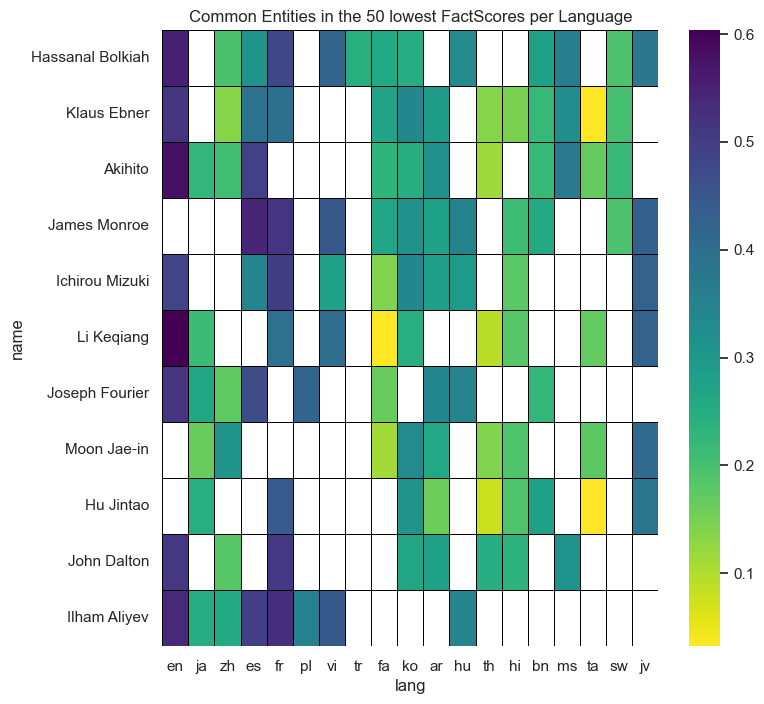

In [69]:
N = 50
top_per_language = fs_name_df[(fs_name_df['experiment'] == 'multi') & (fs_name_df['model'] == 'qwen_72')].groupby('lang').apply(lambda x: x.nsmallest(N, 'fs_mean'))
top_pivot = top_per_language.pivot(index='name', columns='lang', values='fs_mean')
top_pivot=top_pivot.reindex(languages, axis=1)
non_nan_counts = top_pivot.count(axis=1)
top_pivot['non_nan_count'] = non_nan_counts
top_pivot=top_pivot.sort_values('non_nan_count', ascending=False)
top_pivot=top_pivot[top_pivot.non_nan_count>7]

plt.figure(figsize=(8, 8))
sns.heatmap(top_pivot.iloc[:, :-1], cmap='viridis_r', linewidths=0.5, linecolor='black')
plt.title('Common Entities in the 50 lowest FactScores per Language')
plt.show()

lang                           ar  bn        en        es        fa        fr  \
name                                                                            
Aamir Khan               0.899252 NaN  0.929813  0.886852       NaN  0.895025   
Abraham Lincoln               NaN NaN       NaN       NaN  0.953488       NaN   
Adam Smith               0.890068 NaN  0.873350       NaN       NaN       NaN   
Adele                    0.882184 NaN  0.883454       NaN       NaN  0.857913   
Adolf Hitler             0.955224 NaN       NaN       NaN       NaN       NaN   
...                           ...  ..       ...       ...       ...       ...   
Winston Churchill             NaN NaN       NaN       NaN       NaN       NaN   
Wolfgang Amadeus Mozart       NaN NaN       NaN       NaN       NaN       NaN   
Woodrow Wilson                NaN NaN       NaN  0.863344       NaN       NaN   
Yasunari Kawabata             NaN NaN       NaN       NaN       NaN       NaN   
Émile Durkheim              

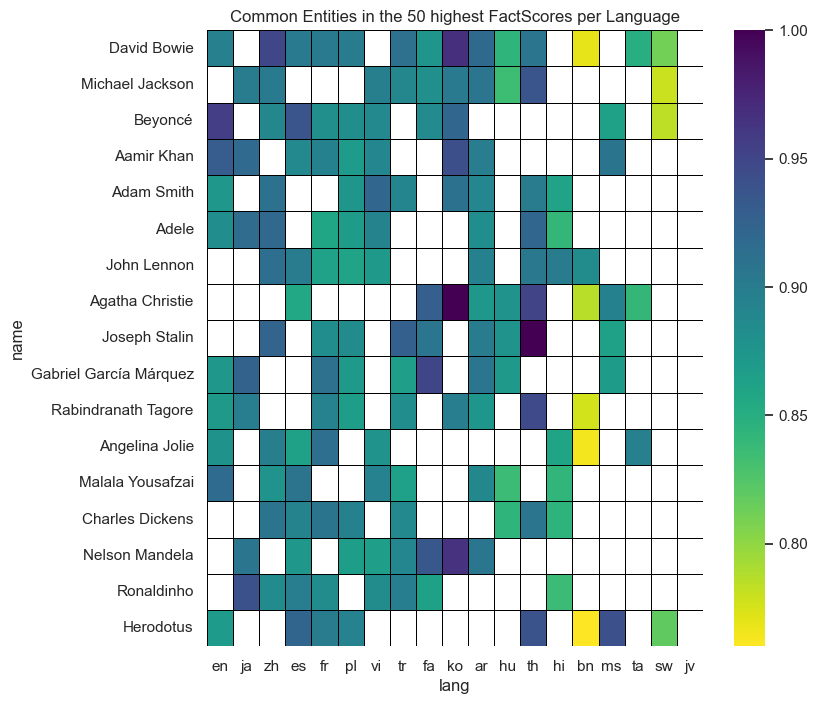

In [39]:
N = 50
top_per_language = fs_name_df[(fs_name_df['experiment'] == 'enprompt') & (fs_name_df['model'] == 'qwen_72')].groupby('lang').apply(lambda x: x.nlargest(N, 'fs_mean'))
top_pivot = top_per_language.pivot(index='name', columns='lang', values='fs_mean')
top_pivot=top_pivot.reindex(languages, axis=1)
non_nan_counts = top_pivot.count(axis=1)
top_pivot['non_nan_count'] = non_nan_counts
top_pivot=top_pivot.sort_values('non_nan_count', ascending=False)
top_pivot=top_pivot[top_pivot.non_nan_count>7]

plt.figure(figsize=(8, 8))
sns.heatmap(top_pivot.iloc[:, :-1], cmap='viridis_r', linewidths=0.5, linecolor='black')
plt.title('Common Entities in the 50 highest FactScores per Language')
plt.show()

In [41]:
fs_job_df=result_df.merge(pers_df[['link', 'occupation']])
top_jobs=fs_job_df.occupation.value_counts().nlargest(15).index

In [42]:
top_jobs

Index(['politician', 'writer', 'actor', 'physicist', 'sportsperson',
       'philosopher', 'artist', 'mathematician', 'singer', 'ruler', 'explorer',
       'film director', 'songwriter', 'religious person',
       'business professional'],
      dtype='object')

In [43]:
set(lang_cat.values())

{'High', 'Low', 'Medium', 'Very-High'}

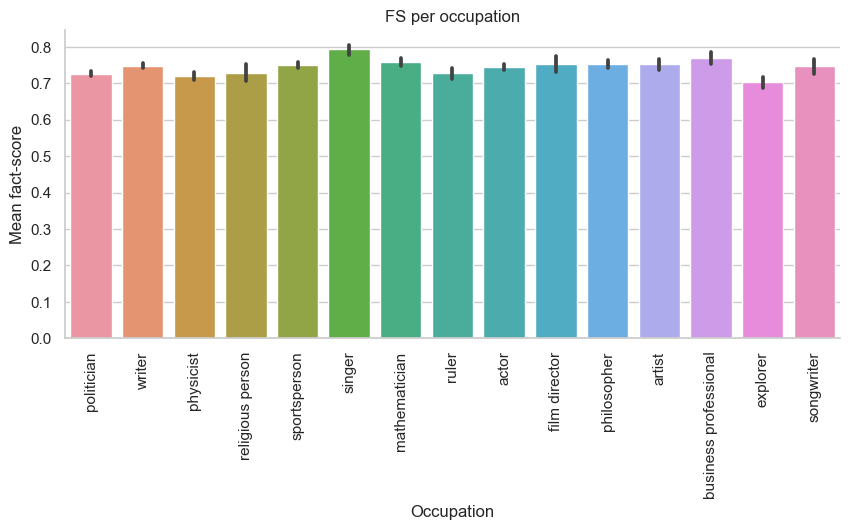

In [46]:
df_filtered=fs_job_df[(fs_job_df.experiment=='enprompt')&(fs_job_df.model=='qwen_72')&(fs_job_df.occupation.isin(top_jobs))]
fig,ax=plt.subplots(figsize=(10,4))
sns.barplot(x=df_filtered.occupation, y=df_filtered.fs_mean)
sns.despine(bottom = False, left = False)
plt.xticks(rotation=90)
plt.xlabel('Occupation')
plt.ylabel('Mean fact-score')
plt.title(f"FS per occupation")
plt.show()

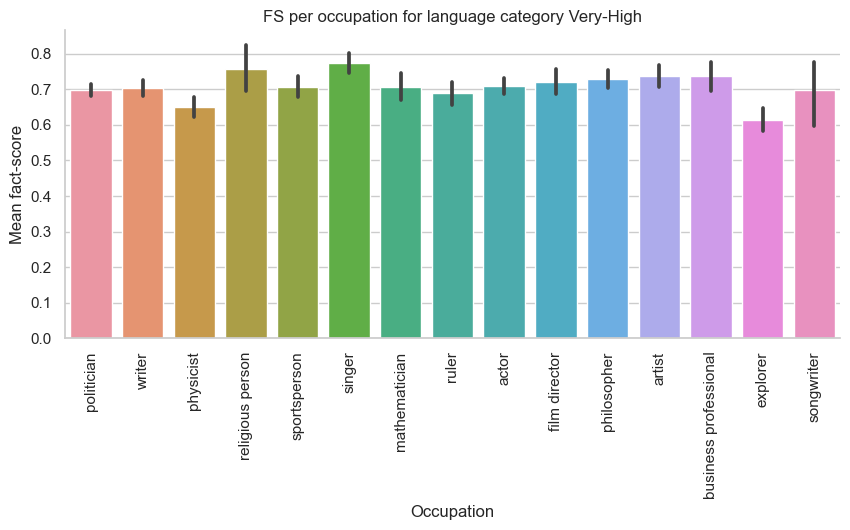

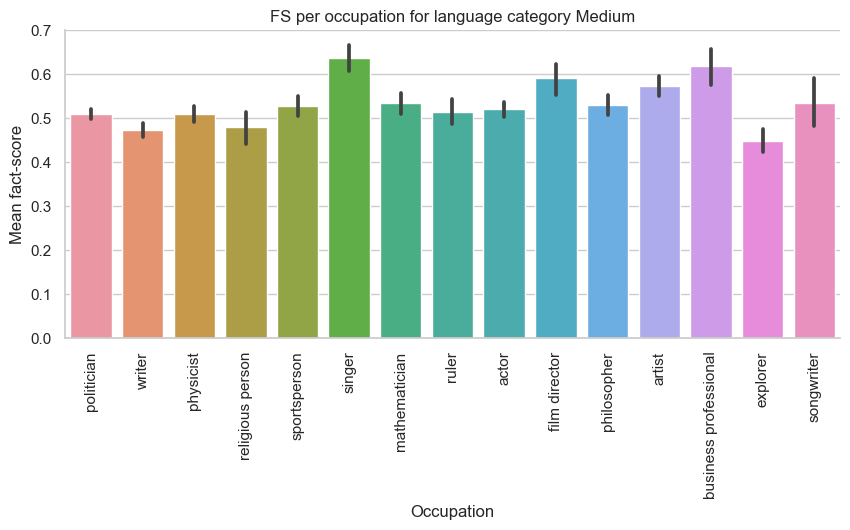

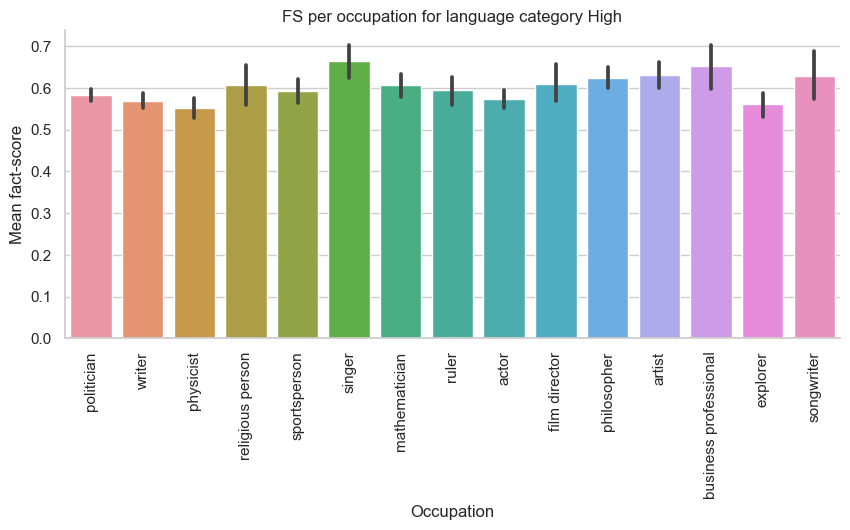

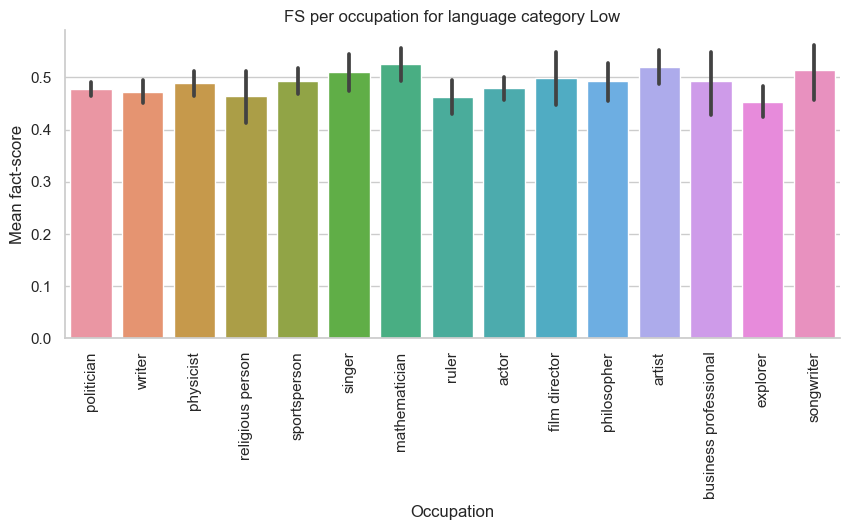

In [48]:
for cat in set(lang_cat.values()):
    df_filtered=fs_job_df[(fs_job_df.experiment=='multi')&(fs_job_df.model=='qwen_72')&(fs_job_df.occupation.isin(top_jobs))&(fs_job_df.lang_cat==cat)]
    fig,ax=plt.subplots(figsize=(10,4))
    sns.barplot(x=df_filtered.occupation, y=df_filtered.fs_mean)
    sns.despine(bottom = False, left = False)
    plt.xticks(rotation=90)
    plt.xlabel('Occupation')
    plt.ylabel('Mean fact-score')
    plt.title(f"FS per occupation for language category {cat}")
    plt.show()

## ROUGE and NLI metrics

In [49]:
rouge_fs=result_df[~result_df.r1_f1_mean.isna()]
rouge_fs

,link,experiment,lang,model,fs_mean,fs_std,nb_facts_mean,nb_facts_std,init_score,respond_ratio,...,r1_p_mean,r1_p_std,r1_r_mean,r1_r_std,rl_f1_mean,rl_f1_std,rl_p_mean,rl_p_std,rl_r_mean,rl_r_std
0,http://www.wikidata.org/entity/Q34981,multi,en,llama_8,0.805515,0.018318,80.666667,5.557777,0.805515,1.0,...,0.465645,0.023513,0.518408,0.025832,0.210002,0.030308,0.199339,0.028982,0.221891,0.031810
1,http://www.wikidata.org/entity/Q34981,multi,ja,llama_8,0.643056,0.160162,16.333333,1.247219,0.643056,1.0,...,0.139260,0.028065,0.358025,0.076104,0.166562,0.033179,0.116213,0.025247,0.296296,0.052378
2,http://www.wikidata.org/entity/Q34981,multi,zh,llama_8,0.606250,0.043750,18.000000,2.000000,0.606250,1.0,...,0.120785,0.066678,0.500000,0.074227,0.152602,0.078044,0.099451,0.054439,0.424242,0.077258
3,http://www.wikidata.org/entity/Q34981,multi,es,llama_8,0.681369,0.054873,56.666667,1.247219,0.681369,1.0,...,0.454608,0.033093,0.444773,0.044891,0.195394,0.015390,0.197647,0.012970,0.193294,0.017806
4,http://www.wikidata.org/entity/Q34981,multi,fr,llama_8,0.681128,0.020096,63.000000,6.164414,0.681128,1.0,...,0.580819,0.004242,0.462636,0.022654,0.200945,0.005315,0.226975,0.009548,0.180521,0.006283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149563,http://www.wikidata.org/entity/Q34969,enprompt,hu,aya_35,0.556039,0.086814,26.000000,2.943920,0.556039,1.0,...,0.421757,0.123530,0.111739,0.016442,0.123555,0.022063,0.291655,0.063002,0.079096,0.015606
149564,http://www.wikidata.org/entity/Q34969,enprompt,th,aya_35,0.717915,0.059750,17.666667,6.342099,0.749074,1.0,...,0.625956,0.076374,0.072819,0.011944,0.085951,0.013802,0.412295,0.036391,0.048336,0.008878
149565,http://www.wikidata.org/entity/Q34969,enprompt,hi,aya_35,0.625397,0.063392,33.666667,0.942809,0.625397,1.0,...,0.663754,0.000209,0.143754,0.009886,0.136185,0.003558,0.383548,0.014659,0.082863,0.003075
149566,http://www.wikidata.org/entity/Q34969,enprompt,bn,aya_35,0.585617,0.057566,26.333333,2.054805,0.585617,1.0,...,0.584596,0.032487,0.084118,0.007102,0.100963,0.005093,0.401629,0.009380,0.057753,0.003201


In [50]:
correlations = rouge_fs.groupby(['experiment', 'model']).apply(lambda x: x['fs_mean'].corr(x['rl_f1_mean'], method='pearson'))
correlation_df = pd.DataFrame(correlations, columns=['Pearson Correlation']).reset_index()
correlation_df

,experiment,model,Pearson Correlation
0,enprompt,aya_35,0.438715
1,enprompt,aya_8,0.501003
2,enprompt,llama_70,0.022673
3,enprompt,llama_8,0.091845
4,enprompt,qwen_7,0.489545
5,enprompt,qwen_72,0.263701
6,multi,aya_35,0.543118
7,multi,aya_8,0.521660
8,multi,llama_70,0.142535
9,multi,llama_8,0.312762


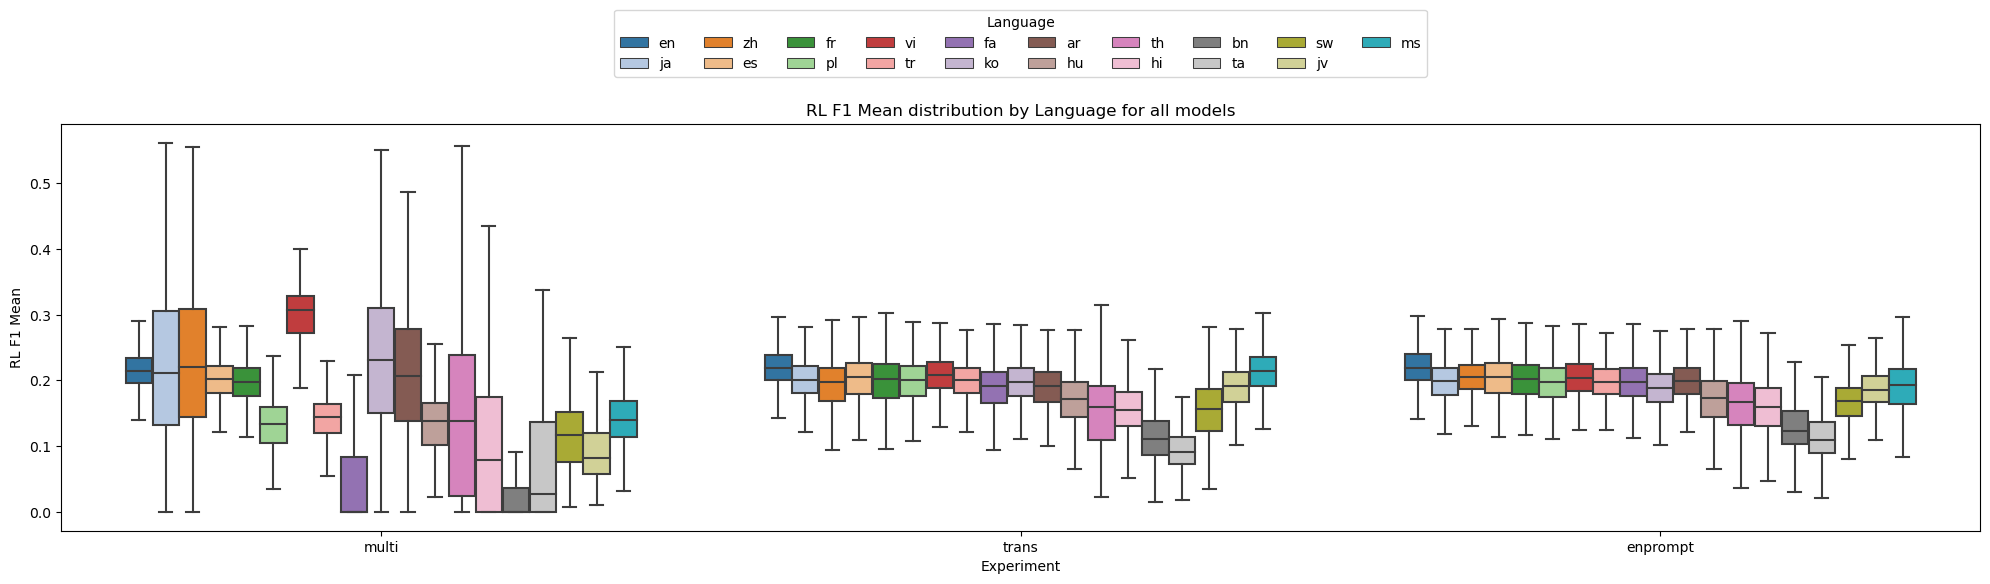

In [51]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='experiment', y='rl_f1_mean', hue='lang', data=rouge_fs, showfliers=False, palette='tab20')
plt.legend(title='Language',
    bbox_to_anchor=(0.5, 1.1),  # Position the legend outside the plot
    loc='lower center',       # Anchor the legend at the top-left corner of the bounding box
    ncol=10                 # Arrange legend items in 2 columns (horizontal)
)
plt.xlabel('Experiment')
plt.ylabel('RL F1 Mean')
plt.title(f'RL F1 Mean distribution by Language for all models')
#tikzplotlib.save(fig_dir+f"fs_{model}.tex")
#reformat(fig_dir+f"fs_{model}.tex")
plt.tight_layout()
plt.show()

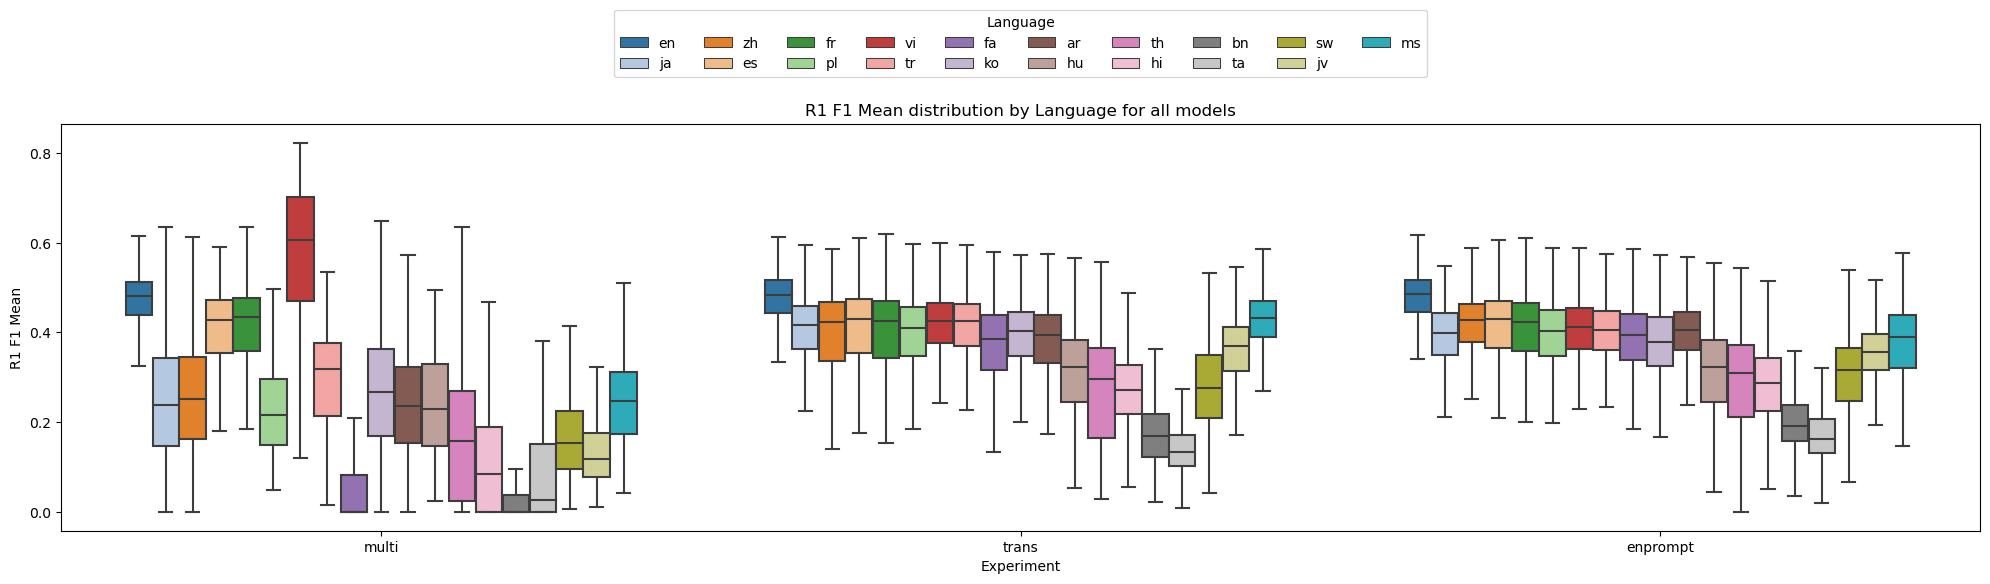

In [52]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='experiment', y='r1_f1_mean', hue='lang', data=rouge_fs, showfliers=False, palette='tab20')
plt.legend(title='Language',
    bbox_to_anchor=(0.5, 1.1),  # Position the legend outside the plot
    loc='lower center',       # Anchor the legend at the top-left corner of the bounding box
    ncol=10                 # Arrange legend items in 2 columns (horizontal)
)
plt.xlabel('Experiment')
plt.ylabel('R1 F1 Mean')
plt.title(f'R1 F1 Mean distribution by Language for all models')
#tikzplotlib.save(fig_dir+f"fs_{model}.tex")
#reformat(fig_dir+f"fs_{model}.tex")
plt.tight_layout()
plt.show()

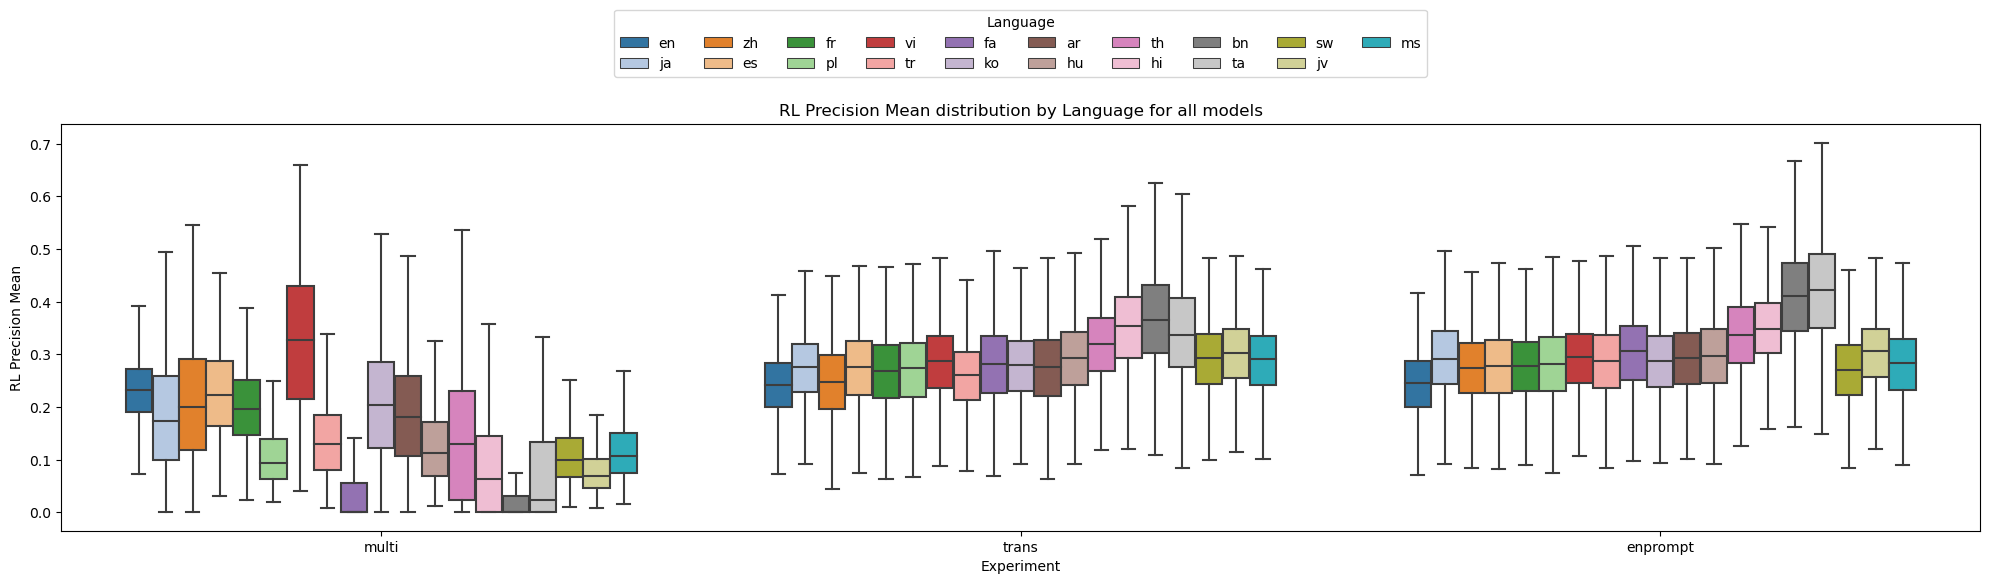

In [54]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='experiment', y='rl_p_mean', hue='lang', data=rouge_fs, showfliers=False, palette='tab20')
plt.legend(title='Language',
    bbox_to_anchor=(0.5, 1.1),  # Position the legend outside the plot
    loc='lower center',       # Anchor the legend at the top-left corner of the bounding box
    ncol=10                 # Arrange legend items in 2 columns (horizontal)
)
plt.xlabel('Experiment')
plt.ylabel('RL Precision Mean')
plt.title(f'RL Precision Mean distribution by Language for all models')
#tikzplotlib.save(fig_dir+f"fs_{model}.tex")
#reformat(fig_dir+f"fs_{model}.tex")
plt.tight_layout()
plt.show()

In [10]:
nli_fs=result_df[~result_df.ent_mean.isna()]
nli_fs

,link,experiment,lang,model,fs_mean,fs_std,nb_facts_mean,nb_facts_std,init_score,respond_ratio,...,rl_p_mean,rl_p_std,rl_r_mean,rl_r_std,ent_mean,ent_std,con_mean,con_std,diff_mean,diff_std
0,http://www.wikidata.org/entity/Q34981,multi,en,llama_8,0.805515,0.018318,80.666667,5.557777,0.805515,1.0,...,0.199339,0.028982,0.221891,0.031810,0.002990,0.001966,0.000611,0.000143,0.002379,0.001830
1,http://www.wikidata.org/entity/Q34981,multi,ja,llama_8,0.643056,0.160162,16.333333,1.247219,0.643056,1.0,...,0.116213,0.025247,0.296296,0.052378,0.009573,0.002685,0.002328,0.001001,0.007246,0.001744
2,http://www.wikidata.org/entity/Q34981,multi,zh,llama_8,0.606250,0.043750,18.000000,2.000000,0.606250,1.0,...,0.099451,0.054439,0.424242,0.077258,0.009497,0.002397,0.001823,0.000474,0.007674,0.002077
3,http://www.wikidata.org/entity/Q34981,multi,es,llama_8,0.681369,0.054873,56.666667,1.247219,0.681369,1.0,...,0.197647,0.012970,0.193294,0.017806,0.002578,0.001128,0.000603,0.000092,0.001976,0.001035
4,http://www.wikidata.org/entity/Q34981,multi,fr,llama_8,0.681128,0.020096,63.000000,6.164414,0.681128,1.0,...,0.226975,0.009548,0.180521,0.006283,0.000867,0.000217,0.000274,0.000033,0.000593,0.000191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149563,http://www.wikidata.org/entity/Q34969,enprompt,hu,aya_35,0.556039,0.086814,26.000000,2.943920,0.556039,1.0,...,0.291655,0.063002,0.079096,0.015606,0.743986,0.315800,0.180149,0.249750,0.563837,0.565465
149564,http://www.wikidata.org/entity/Q34969,enprompt,th,aya_35,0.717915,0.059750,17.666667,6.342099,0.749074,1.0,...,0.412295,0.036391,0.048336,0.008878,0.460241,0.382086,0.024633,0.023196,0.435609,0.404334
149565,http://www.wikidata.org/entity/Q34969,enprompt,hi,aya_35,0.625397,0.063392,33.666667,0.942809,0.625397,1.0,...,0.383548,0.014659,0.082863,0.003075,0.068223,0.077590,0.016596,0.012077,0.051626,0.075788
149566,http://www.wikidata.org/entity/Q34969,enprompt,bn,aya_35,0.585617,0.057566,26.333333,2.054805,0.585617,1.0,...,0.401629,0.009380,0.057753,0.003201,0.571057,0.404966,0.038821,0.037199,0.532236,0.398415


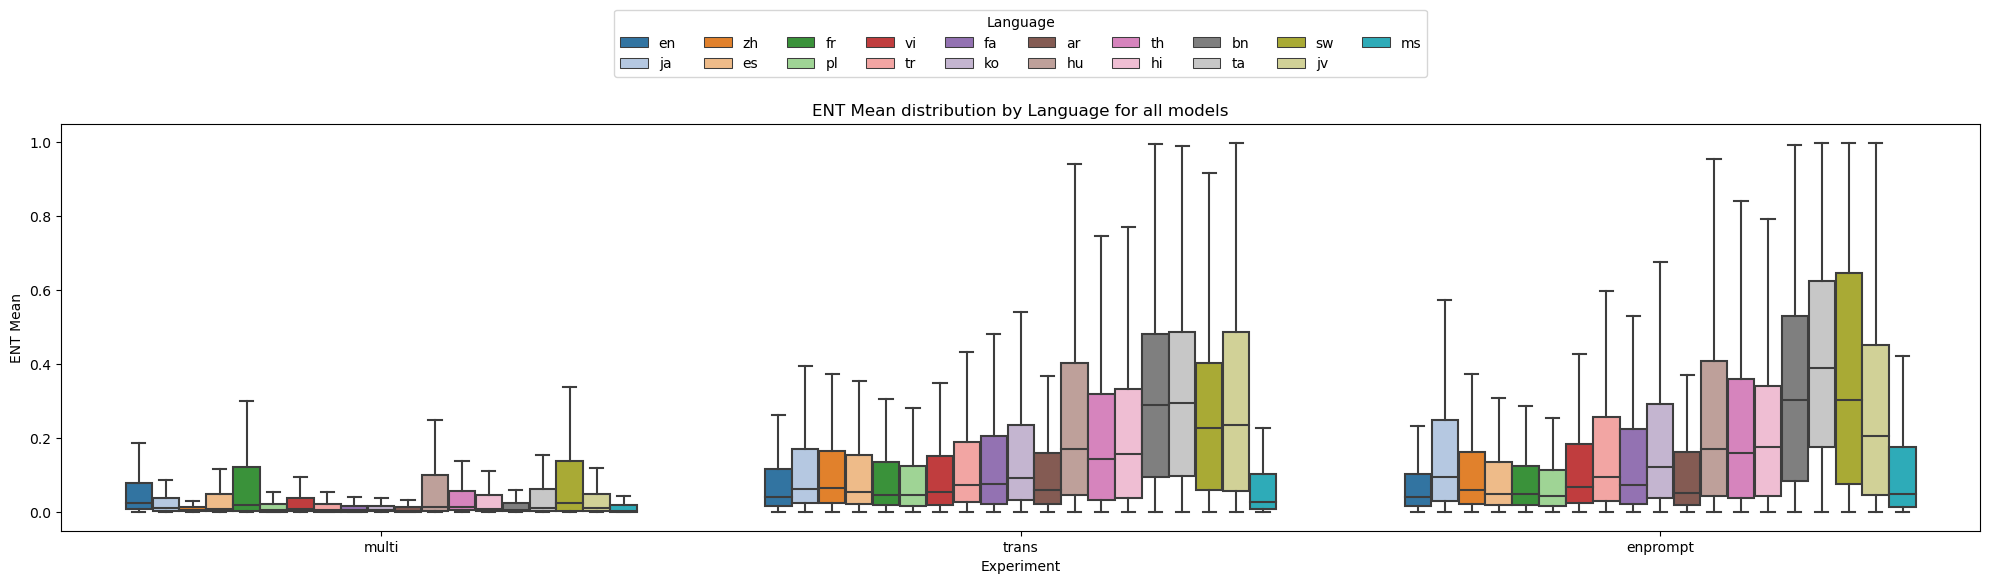

In [14]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='experiment', y='ent_mean', hue='lang', data=nli_fs, showfliers=False, palette='tab20')
plt.legend(title='Language',
    bbox_to_anchor=(0.5, 1.1),  # Position the legend outside the plot
    loc='lower center',       # Anchor the legend at the top-left corner of the bounding box
    ncol=10                 # Arrange legend items in 2 columns (horizontal)
)
plt.xlabel('Experiment')
plt.ylabel('ENT Mean')
plt.title(f'ENT Mean distribution by Language for all models')
#tikzplotlib.save(fig_dir+f"fs_{model}.tex")
#reformat(fig_dir+f"fs_{model}.tex")
plt.tight_layout()

## Atomic facts translated

In [4]:
def py3lang_detect(text):
    '''Detect the language of the provided text, as well as other probable languages'''
    lang, prob = langid.classify(text)
    return lang

In [5]:
rows=[]
for model in models:
    result_file=results_dir+f'multi_scores_{model}.json'
    with open(result_file, 'r') as f:
        data=json.load(f)
    
    for link, lang_dict in tqdm(data.items()):
        for lang, res_dict in lang_dict.items():
            if res_dict:
                decisions=res_dict['decisions']
                count=0
                for gen in decisions:
                    try:
                        lang_atoms_facts=[py3lang_detect(atom_fact['atom']) for atom_fact in gen]
                        english_score=np.mean([language=='en' for language in lang_atoms_facts])
                        original_score=np.mean([language==lang for language in lang_atoms_facts])
                        new_row={'link':link, 'lang': lang, 'model': model, 'generation':count,
                        'atom_fact_en': english_score, 'atom_fact_lang': original_score,}
                        rows.append(new_row)
                    except:
                        pass

100%|██████████| 486/486 [04:04<00:00,  1.99it/s]


In [17]:
rows

[{'link': 'http://www.wikidata.org/entity/Q34981',
  'lang': 'en',
  'model': 'llama_8',
  'generation': 0,
  'atom_fact_en': 0.9651162790697675,
  'atom_fact_lang': 0.9651162790697675},
 {'link': 'http://www.wikidata.org/entity/Q34981',
  'lang': 'en',
  'model': 'llama_8',
  'generation': 0,
  'atom_fact_en': 0.9863013698630136,
  'atom_fact_lang': 0.9863013698630136},
 {'link': 'http://www.wikidata.org/entity/Q34981',
  'lang': 'en',
  'model': 'llama_8',
  'generation': 0,
  'atom_fact_en': 0.9518072289156626,
  'atom_fact_lang': 0.9518072289156626},
 {'link': 'http://www.wikidata.org/entity/Q34981',
  'lang': 'ja',
  'model': 'llama_8',
  'generation': 0,
  'atom_fact_en': 1.0,
  'atom_fact_lang': 1.0},
 {'link': 'http://www.wikidata.org/entity/Q34981',
  'lang': 'ja',
  'model': 'llama_8',
  'generation': 0,
  'atom_fact_en': 0.9375,
  'atom_fact_lang': 0.9375},
 {'link': 'http://www.wikidata.org/entity/Q34981',
  'lang': 'ja',
  'model': 'llama_8',
  'generation': 0,
  'atom_fac

In [7]:
lang_atom_df=pd.DataFrame(rows, columns=['link', 'lang', 'model', 'generation', 'atom_fact_en', 'atom_fact_lang'])

In [11]:
lang_atom_df[['lang', 'atom_fact_lang']].groupby('lang').mean().sort_values(by='atom_fact_lang')

,atom_fact_lang
lang,
fa,0.008057
hi,0.008569
ar,0.013179
bn,0.022158
ms,0.047526
ta,0.057138
jv,0.057553
ja,0.075572
tr,0.085171
